## Import libraries and save global variables

In [1]:
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
from collections import Counter, OrderedDict

# NLP
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import RegexpTokenizer
from PIL import Image
from wordcloud import WordCloud

# Sklearn
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

proxies = {'http': 'http://206.189.157.23'}
abspath_song_info = ("/mnt/processed/private/msds2023/lt2/DMW1_Project/"
                     "all_songs.pkl")
%matplotlib inline

# Pandas settings
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('mode.chained_assignment', None)

# Error Filters
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

# Colors
c_black = '#000000'
c_gray = '#657786'
c_blue = '#1a48c4'
c_white = '#ffffff'
c_red = '#b91c20'
c_green = '#00e091'

## Utility functions

In [3]:
stopwords = ['out', 'wont', 'for', 'shan', 'mightn', 'mightnt', 'ya', 're',
             'itself', 'you', 'aren', 'off', 'id', 'que', 'doing', 'nor',
             'ooh', 'un', 'weren', 'are', 'uh', 's', 'between', 'your',
             'that', 'they', 'as', 'ill', 'all', 'ahh', 'does', 'she',
             'thatll', 'can', 'isn', 'my', 'ourselves', 'ain', 'hadn',
             'being', 'to', 'a', 'if', 'any', 'arent', 'down', 'have', 'has',
             'having', 've', 'because', 'y', 'the', 'll', 'needn', 'mi',
             'both', 'no', 'what', 'other', 'those', 'these', 'herself', 'do',
             'then', 'of', 'been', 'didn', 'la', 'again', 'yourself', 'under',
             'mustn', 'ma', 'couldnt', 'woah', 'hee', 'le', 'o', 'had', 'am',
             'neednt', 'd', 'oh', 'which', 'myself', 'by', 'each', 'with',
             'wouldnt', 'da', 'and', 'but', 'how', 'los', 'ours', 'hers',
             'against', 'only', 'ayy', 'hes', 'ah', 'lo', 'until', 'hasnt',
             'hey', 'before', 'an', 'now', 'than', 'up', 'when', 'himself',
             'yeah', 'yours', 'more', 'werent', 'i', 'dont', 'wasn', 'there',
             'further', 'whoa', 'wasnt', 'at', 'haven', 'in', 'while', 'is',
             'through', 'above', 'from', 'hu', 'their', 'youve', 'na', 'most',
             'them', 'wouldn', 'or', 'why', 'isnt', 'youre', 'me', 'same',
             'where', 'shes', 'we', "i'll", 'tu', 'don', 'im', 'de', 'ese',
             'just', 'very', 'during', 'shouldve', 'm', 'havent', 'be',
             'ho', 'yo', 'it', "i'm", 'ive', 'themselves', 'couldn', 'her',
             'youll', 'this', 'shouldnt', 'after', 'ay', 'haa', 'en', 'once',
             'hadnt', 'own', 'theirs', 'its', 'will', 'about', 'some', 'es',
             'youd', 'el', 'our', 'him', 'mustnt', 'not', 'did', 'were',
             'mmm', 'em', 'on', 'didnt', 'whom', 'below', 'won', 'his', 'he',
             'over', 'te', 'here', 'such', 'too', 'should', 'few', 'shant',
             'was', 'into', 'hasn', 'yourselves', 'who', 't', 'so', 'doesn',
             'ha', 'doesnt', 'eh', 'shouldn', 'ye', 'pa', 'si', 'se', 'nah',
             'aint', 'huh', 'cause', 'one', 'well', 'let', 'thats', 'could',
             'every', 'even', 'gotta', 'around', 'gonna', 'really', 'gon',
             'ever', 'bout', 'us', 'lets', 'theres', 'two', 'much',
             'whats', 'might', 'til', 'ima', 'another', 'something'
             ]


def preprocess_lyrics(lyrics):
    """Returns cleaned lyrics."""
    # Convert to lowercase
    lyrics = lyrics.lower()

    # Removes titles
    lyrics = lyrics.split('yrics\n', 1)[-1]

    # Removes 'Embed from the end'
    lyrics = lyrics.rsplit('embed', 1)[0]

    # Removes digits before embed
    lyrics = lyrics.rstrip('1234567890')

    # Removes 'you might also like'
    lyrics = lyrics.rsplit('you might also like', 1)[0]

    # Replace dash with space
    lyrics = (re.sub("[-]", " ", lyrics))

    # Remove Non-letters
    lyrics = (re.sub("[^\sA-Za-z]", "", lyrics))

    # Standardize whitespace
    lyrics = (re.sub("[\s]", " ", lyrics))

    # Lemmatizer
    lemma = WordNetLemmatizer()
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        lyrics_clean = " ".join(lemma.lemmatize(word, pos)
                                for word in lyrics.split())

    return lyrics_clean


def df_info(df):
    """Returns the dimensions, info, and statistics of a given data frame."""
    # Get the dimensions of the df
    print(f'Number of rows: {df.shape[0]}\n'
          f'Number of columns: {df.shape[1]}\n')

    # List the datatype of each column and count of non-null values
    print(f'List of all columns, count of non-null values, and datatypes of '
          'the df:\n')
    display(df.info())

    # Get summary statistics for the numerical columns and transpose the DataFrame
    # for more readable output
    print(f'\nSummary statistics for numerical columns:\n')
    display(df.describe())

    # Get summary statistics for the object (string) columns
    print(f'Summary statistics for object(string) columns:\n')
    display(df.describe(include=[object]).T)

    # Get count of null values
    print(f'Check for null columns:\n')
    display(df.isna().sum())

    # display % of null values per column
    print(f'Display % of null columns:\n')
    display(df.isna().sum() / (len(df))*100)


def pairwise(iterable):
    """Function used for pairwise iteration."""
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)


def plot_word_cloud(nmf_model, feature_names, k=300, n_topics=4):
    """Return an n_topics-2 rows by 3 columns wordclouds of the words
    per topic."""
    topic_word_list = []
    for index, topic in enumerate(nmf_model.components_):
        terms_comp = zip(feature_names, topic)
        sorted_terms = sorted(
            terms_comp, key=lambda x: x[1], reverse=True)[:k]
        topic = " "
        for t in sorted_terms:
            topic = topic + ' ' + t[0]
        topic_word_list.append(topic)
    ncols = 3
    nrows = 2
    fig = plt.figure(figsize=(15, 10))
    for i in range(n_topics):
        ax = fig.add_subplot(nrows, ncols, i+1)
        wc = WordCloud(background_color='white',
                       colormap='winter',
                       max_words=k,
                       contour_color=c_blue,
                       contour_width=2,
                       font_step=2,
                       relative_scaling=0,
                       random_state=42).generate(topic_word_list[i])
        plt.imshow(wc)
        plt.title(f"Topic {i+1}", color=c_blue, fontsize=24, weight='bold')
        plt.axis("off")
        plt.tight_layout()


def get_tfidf(df):
    """Converts the song lyrics to a matrix of TF-IDF features. """
    corpus = df['lyrics'].tolist()
    vectorizer = TfidfVectorizer(
        min_df=3, max_df=0.50, ngram_range=(1, 3), stop_words=stopwords)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    return X, feature_names


def truncated_svd(X):
    """Return the Q, Sigma, and P SVD of the design matrix X as well as the
    normalized sum of squared distance from the origin.
    """
    q, s, p = np.linalg.svd(X)
    s2 = s ** 2
    return q, np.diag(s), p.T, (s2 / np.sum(s2))


def plot_sv(nssd, thresh=0.95, title=None):
    """Plot cumulative variance explained of a given nssd to have an idea
    on the value of k."""
    svs = (sum(nssd.cumsum() < thresh) + 1)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(range(1, len(nssd)+1), nssd.cumsum(), c_green, label='cumulative',
            linewidth=5)
    ax.axhline(thresh, ls='--', color=c_red)
    ax.axvline(svs, ls='--', color=c_red)
    ax.set_xlim(0, len(nssd)+1)
    ax.set_xlabel('SV', fontsize=16, c=c_black)
    ax.set_ylabel('cumulative variance explained', fontsize=16, c=c_black)
    ax.set_title(f'{title}: Retained {svs} SVs',
                 fontsize=24, color=c_black, weight='bold')
    plt.tight_layout()
    return svs


def project_svd(q, s, k):
    """Returns design matrix projected on to the first k singular vectors"""
    return q[:, :k]@s[:k, :k]


def topics(rows, cols, features, p):
    """Plot top rxc topics based on the given matrix"""
    p = np.asarray(p)
    fig, ax = plt.subplots(nrows=rows, ncols=cols,
                           figsize=(7*cols, 7+rows*2),
                           sharex=True)
    for i, ax in enumerate(ax.flat):
        rank = np.argsort(np.abs(p[:, i]))[-10:]
        ax.barh([features[r] for r in rank], p[rank, i], color=c_green)
        ax.set_title(f'SV{i+1}', fontsize=14, c=c_black)
    plt.suptitle(f'Top {rows*cols} topics uncovered', fontsize=24,
                 color=c_black, weight='bold')
    plt.rc('legend', fontsize=20)
    plt.tight_layout()


def get_top_100(soup):
    """Returns the rank, song, and artist of the top 100 songs from
    Billboard.com"""
    songs = [x.text.strip() for x in soup.select('li .c-title')]
    artists = [x.text.strip() for x in soup.select('li .c-title ~ .c-label')]
    return {rank: {'song': song, 'artist': artist} for rank,
            (song, artist) in enumerate(zip(songs, artists), start=1)}


def artist_songs_stats():
    """Print average number of songs per artist and the artist with the most
    number of songs in the dataset, then plot the histogram of the songs
    per artist."""
    songs_per_artist = OrderedDict(
        Counter(df_all.artist).most_common()).values()
    avg_song_per_artist = np.mean(list(songs_per_artist))
    max_song_of_artist = np.max(list(songs_per_artist))
    artist_most_n_songs = list(OrderedDict(
        Counter(df_all.artist).most_common()))[0]
    print(f'Average number of songs per artist: {avg_song_per_artist:.2f}')
    print(f'{artist_most_n_songs} had the most number of songs with '
          f'{max_song_of_artist:.0f} songs')
    fig = plt.figure(figsize=(10, 5))
    plt.hist(songs_per_artist, color=c_green, bins=24)
    plt.xlabel("Number of songs", fontsize=16)
    plt.ylabel("Number of artists", fontsize=16)
    plt.title("Distribution of songs per artist", fontsize=24, weight='bold')
    plt.xlim(0, 25)
    plt.plot()


def n_words_in_lyrics():
    """Print average number of words per song lyrics and plots its
    distribution."""
    # Words per song
    word_counts = [len(df_all.lyrics.str.split(' ')[i]) for i in df_all.index]
    filtered = list(filter(lambda x: x < 900, word_counts))
    avg_words_lyrics = np.mean(filtered)
    print(f'Average words in song lyrics: {avg_words_lyrics:.0f} words')
    fig, axs = plt.subplots(figsize=(10, 5))

    axs.hist(filtered, bins=100, color=c_green)
    axs.set_xlabel("Words in song", fontsize=16)
    axs.set_ylabel("Number of songs", fontsize=16)
    axs.set_title("Distribution of words per song lyrics",
                  fontsize=24, weight='bold')
    # Hide the right and top spines
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    plt.show()

def get_countvec(df, n=10):
    """Returns the top words and how much it is used in the era."""
    corpus = df['lyrics'].tolist()
    vectorizer = CountVectorizer(
        min_df=3, max_df=0.50, ngram_range=(1, 3), stop_words=stopwords)
    X = vectorizer.fit_transform(corpus)
    features = vectorizer.get_feature_names_out()
    df_top_words = pd.DataFrame()
    X = X.todense().astype(bool).sum(axis=0)
    df_top_words['count'] = pd.DataFrame(X, columns=features).T.nlargest(n, 0)
    df_top_words['% of songs'] = df_top_words['count'] / df.shape[0] * 100
    return df_top_words

def top_words_per_era(n=5):
    """Prints the top words from all the three eras."""
    dfs = [df_2006_2010, df_2011_2015, df_2016_2021]
    eras = ["2006-2010", "2011-2015", "2016-2021"]
    for era, df_cv in zip(eras, dfs):
        print(f'{era} era')
        display(get_countvec(df_cv, n))

def n_dimensions():
    """Print the number of dimensions of the lyrics data after performing
    TF-IDF."""
    print(f'All years n_dimensions: {X_all.shape[1]:,.0f}')
    print(f'2006-2010 n_dimensions: {X_0610.shape[1]:,.0f}')
    print(f'2011-2015 n_dimensions: {X_1115.shape[1]:,.0f}')
    print(f'2016-2021 n_dimensions: {X_1621.shape[1]:,.0f}')


def updated_n_dimensions():
    """Print the number of dimensions of the lyrics data after performing
    TF-IDF."""
    print(f'All years n_dimensions: {X_all_lsa.shape[1]:,.0f}')
    print(f'2006-2010 n_dimensions: {X_0610_lsa.shape[1]:,.0f}')
    print(f'2011-2015 n_dimensions: {X_1115_lsa.shape[1]:,.0f}')
    print(f'2016-2021 n_dimensions: {X_1621_lsa.shape[1]:,.0f}')


def optimal_k_nmf(X):
    """Returns a plot showing the optimal K for NMF."""
    # Elbow
    init = "nndsvda"
    fig, ax = plt.subplots(figsize=(10, 5))
    reconstruction_error = []
    K = range(2, 11)
    for k in K:
        nmf = NMF(n_components=k,
                  random_state=42,
                  init=init,
                  beta_loss="frobenius",
                  alpha_W=0.00005,
                  alpha_H=0.00005,
                  l1_ratio=1)
        nmf = nmf.fit(X)
        reconstruction_error.append(nmf.reconstruction_err_)
    k_optimal_nmf = np.argmin(reconstruction_error)+2
    ax.plot(K, reconstruction_error, color=c_green, linewidth=5)
    ax.set_xlabel('k', fontsize=16, c=c_black)
    ax.set_ylabel('Reconstruction Error', fontsize=16, c=c_black)
    ax.set_title('Elbow Method For Optimal k', fontsize=24, c=c_black,
                 weight='bold')
    ax.axvline(k_optimal_nmf, ls='--', c=c_red)
    return f'Optimal K for NMF Topics: {k_optimal_nmf}'


def nmf_topics(X, feature_names, n_words=15):
    """Returns the top 15 words for the K number of topics identified for NMF
    and prints the top 15 words per topic.
    """
    n_components = 6
    nmf_model = NMF(n_components, beta_loss="frobenius",
                    random_state=42, max_iter=500)
    U = nmf_model.fit_transform(X)
    V = nmf_model.components_.T

    for index, topic in enumerate(nmf_model.components_):
        print(f"THE TOP {n_words} WORDS PER TOPIC {index+1}")
        print([feature_names[i] for i in topic.argsort()[-n_words:]])
        print('\n')
    return nmf_model, U, V


def nmf_topics_era(X, feature_names, n_words=15):
    """Returns the top 15 words for the K number of topics identified for NMF
    and prints the top 15 words per topic.
    """
    n_components = 6
    nmf_model = NMF(n_components, beta_loss="frobenius",
                    random_state=42, max_iter=500)
    U = nmf_model.fit_transform(X)
    V = nmf_model.components_.T

    return nmf_model, U, V


def nmf_topics_all(df_all, years=[2006, 2011, 2016, 2022]):
    """DataFrame for topics per era"""
    df_nmf = pd.DataFrame()
    for x, y in pairwise(years):
        df = (
            df_all[df_all['year'].isin(range(x, y))]
            .value_counts('topic')
            .sort_index()
            .to_frame()
        )
        df.columns = [f'{x}-{y-1}']
        df_nmf = pd.concat([df_nmf, df], axis=1)
    return df_nmf


def nmf_topics_year(df_all, years):
    """DataFrame for topics per era"""
    df_nmf = pd.DataFrame()
    for x in years:
        df = (
            df_all[df_all['year'] == x]
            .value_counts('topic')
            .sort_index()
            .to_frame()
        )
        df.columns = [f'{x}']
        df_nmf = pd.concat([df_nmf, df], axis=1).fillna(0).astype(int)
    return df_nmf


def nmf_df(nmf_model, X, df, years):
    """Returns a plot of the most represented topics for each era"""
    topic_results = nmf_model.transform(X)
    df['topic'] = topic_results.argmax(axis=1)+1
    df_nmf = nmf_topics_year(df, years)
    df_nmf.T.plot(figsize=(10, 5))
    plt.legend(loc='upper left')
    plt.title("Most Represented Topic", fontsize=24, weight='bold')
    plt.xlabel("Years", fontsize=24)
    plt.ylabel("Number of Songs", fontsize=24)
    plt.show()
    return df_nmf


def display_topics(df, n_topics=6, samples=True, n_samples=10):
    """Sample per cluster and return dataframe with added topic column."""
    if samples:
        for i in range(1, n_topics+1):
            print(f'Topic {i}')
            try:
                display(df
                        .reset_index().sort_values('rank')
                        .loc[pd.Series(df['topic']) == i,
                             ['rank', 'song', 'artist']]
                        .head(n_samples))
            # If less than n_samples
            except:
                display(df
                        .reset_index().sort_values('rank')
                        .loc[pd.Series(df['topic']) == i,
                             ['rank', 'song', 'artist']]
                        .head())


# Davies Bouldin score for K means
def get_kmeans_score(data, center):
    '''Returns kmeans score regarding Davies Bouldin for points to centers'''

    # instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=42)

    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)

    # Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)

    return score


def optimal_k(X, k_optimal=6):
    """Returns elbow plot to find optimal K using sum of squared distances."""
    # Elbow
    Sum_of_squared_distances = []
    K = range(2, 11)
    for k in K:
        km = KMeans(n_clusters=k, random_state=42)
        km = km.fit(X)
        Sum_of_squared_distances.append(km.inertia_)

    # Silhouette
    from sklearn.metrics import silhouette_score

    sil = []

    # dissimilarity would not be defined for a single cluster, thus,
    # minimum number of clusters should be 2
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        labels = kmeans.labels_
        sil.append(silhouette_score(X, labels, metric='cosine'))

    # Davies Bouldin score
    scores = []
    centers = list(K)
    for center in centers:
        scores.append(get_kmeans_score(X, center))

    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    style = '-og'
    lw = 3
    ms = 7
    mfc = c_green
    c = c_red

    ax[0].plot(K, Sum_of_squared_distances, style, lw=lw, ms=ms, mfc=mfc)
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('Sum of squared distances')
    ax[0].set_title('Elbow Method For Optimal k', fontsize=24, weight='bold')
    ax[0].axvline(k_optimal, ls='--', c=c)

    ax[1].plot(K, sil, style, lw=lw, ms=ms, mfc=mfc)
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('Silhouette score')
    ax[1].set_title('Silhouette score vs. K', fontsize=24, weight='bold')
    ax[1].axvline(k_optimal, ls='--', c=c)

    ax[2].plot(centers, scores, style, lw=lw, ms=ms, mfc=mfc)
    ax[2].set_xlabel('k')
    ax[2].set_ylabel('Davies Bouldin score')
    ax[2].set_title('Davies Bouldin score vs. K', fontsize=24, weight="bold")
    ax[2].axvline(k_optimal, ls='--', c=c)


def nmf_kmeans(X, U, k=6):
    """Plot clustering using most represented NMF topics and K-means"""
    fig, ax = plt.subplots(figsize=(10, 5))

    pca = PCA(2, random_state=42)
    pca_num = len(set(U.argmax(axis=1)))

    kmeans = KMeans(k, random_state=42)
    kmn_num = len(set(kmeans.fit_predict(U)))
    ax.scatter(*pca.fit_transform(X.todense()).T,
               c=kmeans.fit_predict(U), cmap='Set1')
    ax.set_xlabel('PC1', fontsize=16)
    ax.set_ylabel('PC2', fontsize=16)
    ax.set_title(f'Clustering (K-Means) - {kmn_num} clusters', fontsize=24,
                 weight='bold')
    return kmeans.fit_predict(U)


def plot_wcloud_km(df, k=300, n_clusters=6):
    """Return an n_topics-2 rows by 2 columns wordclouds of the words
    per topic."""

    ncols = int(np.ceil(n_clusters/2))
    nrows = 2
    fig = plt.figure(figsize=(14, nrows*(14/ncols)))

    for i in range(n_clusters):
        ax = fig.add_subplot(nrows, ncols, i+1)

        df_i = df[df['k_cluster'] == i]
        df_i_lyrics = df_i['lyrics'].apply(preprocess_lyrics)

        corpus = df_i_lyrics.tolist()
        try:
            cv = CountVectorizer(stop_words=stopwords, min_df=3, max_df=0.50,
                                 ngram_range=(1, 1))
        except:
            cv = CountVectorizer(stop_words=stopwords, min_df=3, max_df=0.80,
                                 ngram_range=(1, 1))
        x = cv.fit_transform(corpus).toarray()
        feature_names = cv.get_feature_names_out()
        bows = pd.DataFrame({'count': x.sum(axis=0), 'word': feature_names})
        bows_sorted = bows.sort_values('count', ascending=False)[
            'word'].tolist()
        bow = " ".join(bows_sorted)

        wc = WordCloud(background_color='white',
                       colormap='winter',
                       max_words=k,
                       contour_color=c_blue,
                       contour_width=3,
                       font_step=2,
                       relative_scaling=0,
                       random_state=42).generate(bow)
        plt.title(f"Km_cluster {i+1}", color=c_red, fontsize=24,
                  weight='bold')
        plt.imshow(wc)
        plt.axis("off")
        plt.tight_layout()
        pl = bows.sort_values("count",ascending=False)["word"][:15].to_numpy()
        print(f'Top 15 words for Km_cluster {i+1}:\n'
              f'{pl}')


def display_k_clusters(df, n_clusters):
    print(df.value_counts('k_cluster').sort_index())
    for i in range(n_clusters):
        print(f'Cluster {i+1}')
        display(df.sort_values('rank').loc[df['k_cluster'] == i,
                                           ['song', 'artist']].head(10))


def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)


def display_clusters(X, df, n_clusters=6, samples=True, t=0.4, n_rows=3):
    """Display dendogram, cluster sizes, sample per cluster and 
    return dataframe with added cluster column."""
    pca = PCA(2, random_state=42)
    data = pca.fit_transform(X)

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=None,
                                    n_clusters=n_clusters,
                                    compute_distances=True,
                                    affinity='cosine',
                                    linkage='average'
                                    )
    model = model.fit(data)

    # Plot
    fig = plt.figure(figsize=(16, 5))
    plt.title("Hierarchical Clustering Dendrogram", fontsize=24,
              weight='bold')
    plot_dendrogram(model, truncate_mode="level", p=4, color_threshold=t)
    plt.xlabel("Number of points in node "
               "(or index of point if no parenthesis).")
    plt.show()
    print(pd.Series(model.labels_).value_counts().sort_index())
    if samples:
        for i in range(n_clusters):
            print(f'Cluster {i+1}')
            try:
                display(df
                        .reset_index().sort_values('rank')
                        .loc[pd.Series(model.labels_) == i,
                             ['rank', 'song', 'artist']]
                        .head(n_rows))
            # If less than 10
            except:
                display(df
                        .reset_index().sort_values('rank')
                        .loc[pd.Series(model.labels_) == i,
                             ['rank', 'song', 'artist']]
                        .head(n_rows))

    # Add cluster columns to df
    df['cluster'] = model.labels_
    return df


def plot_wcloud_ac(df, k=300, n_clusters=6):
    """Return an n_topics-2 rows by 2 columns wordclouds of the words
    per topic."""

    ncols = int(np.ceil(n_clusters/2))
    nrows = 2
    fig = plt.figure(figsize=(14, nrows*(14/ncols)))

    for i in range(n_clusters):
        ax = fig.add_subplot(nrows, ncols, i+1)

        df_i = df[df['cluster'] == i]
        df_i_lyrics = df_i['lyrics'].apply(preprocess_lyrics)

        corpus = df_i_lyrics.tolist()
        cv = CountVectorizer(stop_words=stopwords, min_df=3,
                             ngram_range=(1, 1))
        x = cv.fit_transform(corpus).toarray()
        feature_names = cv.get_feature_names_out()
        bows = pd.DataFrame({'count': x.sum(axis=0), 'word': feature_names})
        bows_sorted = bows.sort_values('count', ascending=False)[
            'word'].tolist()
        bow = " ".join(bows_sorted)

        wc = WordCloud(background_color='white',
                       colormap='winter',
                       max_words=k,
                       contour_color=c_blue,
                       contour_width=3,
                       random_state=42).generate(bow)
        plt.title(f"Cluster {i+1}", color=c_red, fontsize=24)
        plt.imshow(wc)
        plt.axis("off")
        plt.tight_layout()
        pl = bows.sort_values("count",ascending=False)["word"][:15].to_numpy()
        print(f'Top 15 words for Cluster {i+1}:\n'
              f'{pl}\n')

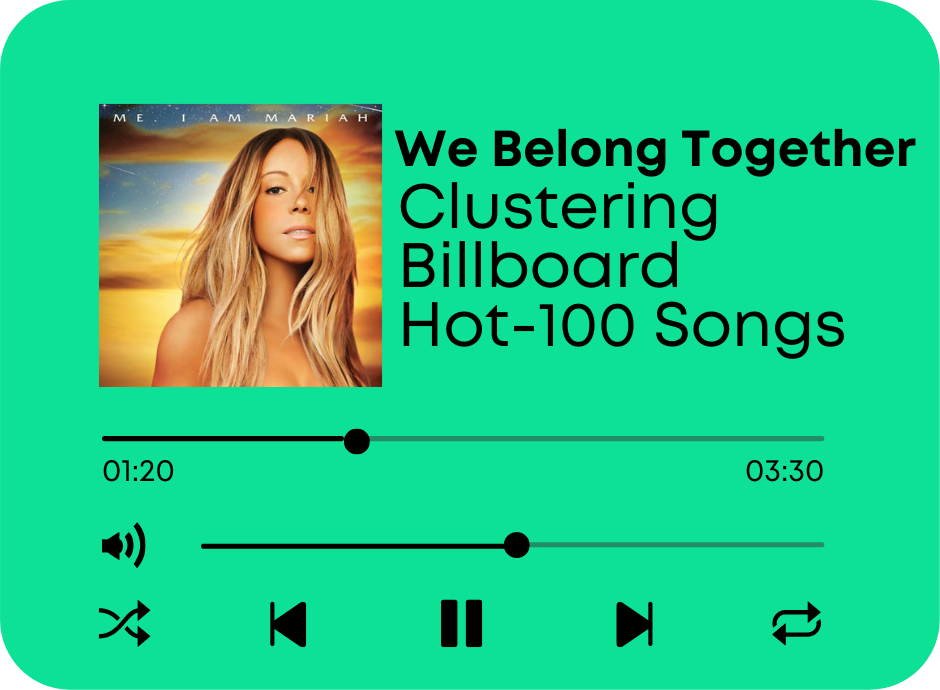

<center><span style="font-size:12px;color:#717171"><b>Figure 1. </b>Title</span></center>

<h1 style="color:#00e091">EXECUTIVE SUMMARY</h1>

Music plays an important role in our society with an implicit effect on emotions, morals, and culture. It is also a way to describe social changes within communities and in the world. Everyday, we hear music as a way to relax, express emotions, exhibit creativity, and to cope with everything that happens with our lives. Different music genres and lyrics connect to us on a different level. Hence, this explains why the global music streaming market size is continuously growing with market size as high as USD 29.45 million in 2022 and is expected to expand with an annual growth rate of 14.7% from 2022 to 2030.

As opposed to how regular playlists are generated in most music streaming sites that utilize genre and existing playlists generated by other users, and given that there is a growing number of huge online societies that are interested and are participating in listening to, obtaining meaning, and expressing their views about various songs' lyrics, such as those hosted by "Last.fm", our team explored clustering songs using moods or social tags related to each song's lyrics to answer the following problem statement:

**What are the common themes based on lyrics that prevailed among the top songs from 2006 to 2021?**

To aid our analysis, the team applied a methodology involving data collection, data preprocessing using webscraping, data exploration by performing exploratory data analysis, converting the lyrics data from string to numerical values using Term Frequency—Inverse Document Frequency (TF-IDF), using dimensionality reduction method such as truncated Singular Value Decomposition (SVD), and applying clustering methods such as Nonnegative Matrix Factorization, K-Means Clustering, and Agglomerative Hierarchical Clustering to finally provide a thematic view of the dataset.

For this report we opted to use the Year-End Hot-100 Songs from Billboard. Despite the collection being generally diverse, this list only contains the most popular songs from 2006 to 2010 based on the metric set by Billboard. We assume that the best or top songs are representative of the songs population for that year.

Before we proceed with the clustering portion, our team used TF-IDF in converting the lyrics data from string to numerical values. After several iterations and review of the results, we ultimately used min_df=3, max_df=50%, ngram_range=(1,3), and manually indentified/listed stop words as our parameters. This yielded an additional 11,262 dimensions in the dataset. Using such new data frame, our team further divided the data between three eras with years 2006-2010, 2011-2015, and 2016-2021 for further thematic analysis.

To reduce the dimensions while retaining 95% of its meaning, we performed dimensionality reduction using truncated SVD which helped us reduce the dimensions from 11,262 to 1,191.

After exploring the three clustering methods, we were able to arrive at the following conclusion:
Overall/all year clustering results yielded `Life, relationships, triumphs`, `Gangster culture, rhythmic, upbeat, and hiphop`, `Passionate, extreme love or loneliness, sexual`, `Rap and sexual`, `Catchy, easy recall, repetitive`, and `Dance and party` as the main themes.

Whereas era clusters resulted to the following:
2006-2010's main themes are `Romantic`, `Dance and Catchy songs`, `Passiona`, `Sexual`, and `Life`.
2011-2015's main themes are `Life`, `Rap + Hip-hop`, `Love`, and `Dance and Party`.
2016-2021's main themes are `Life`, `Rap + Hip-hop`, `Love`, and `Gangster`. 

With these results, our team recommends that for future studies, songwriters and artists can use lyric-based analysis and classification of the top songs over the years. They can use this to identify keywords and themes that recenlty successful songs have, and strategize what messages they want to include when crafting new songs. 
The clusters formed by the models in this study can also be used to generate playlists that have one common theme. While for model improvements, our team identified that we can increase the scope of our data by scraping more songs outside of the Hot-100. We can get more insights from the clustering and analyzing songs that aren't as successful as the top songs. We can also utilize metadata that will help identify the social tags of the clusters such as genre, sub-genres, song length, and others. Aside from the bare lyrics, we can use lyric interpretations from Genius.com or other sources. This will give more information about the context of songs, given that some songs don't directly say the message hidden behind the words. And finally, we can also explore using NMF directly without using the truncated SVD since it is also a dimensionality reduction method that could immediately work on large file and provide the most appropriate clusters.

<h1 style="color:#00e091">PROBLEM STATEMENT</h1>

**What are the common themes based on lyrics that prevailed among the top songs from 2006 to 2021?**

<h1 style="color:#00e091">MOTIVATION</h1>

Given that there is a growing number of huge online communities that are interested and are participating in listening to, obtaining meaning, and expressing their views about various songs' lyrics, such as those hosted by "Last.fm", our team would like to explore using the moods or social tags relevant for each song's lyrics to generate insights about the common themes that prevailed among the top songs from 2006 to 2021.

<h1 style="color:#00e091">METHODOLOGY</h1>

The methodology of this report aims to <b> gather insights from the common themes based on song lyrics that prevailed among the top songs from 2006 to 2021</b>.

The high-level methodology used in this study is as follows:

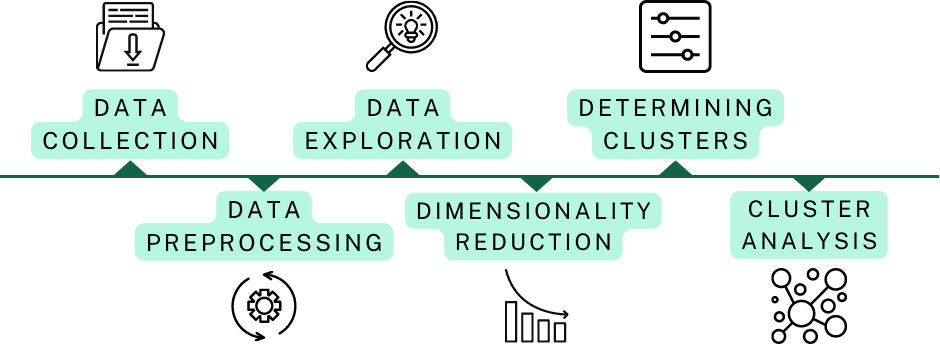
<center><span style="font-size:12px;color:#717171"><b>Figure 2. </b>Methodology</span></center>

| No. | Step | Description |
| -: | :- | :- |
| 1. | **Data Collection** | Scrape the yearly top 100 songs, including the corresponding rank, artist, and year from Billboard.com[[1]](#Billboard) using BeautifulSoup covering the periods from 2006 to 2021. Then scrape the lyrics related to the aforementioned songs from the Genius.com's[[2]](#Genius_API) lyricsgenius library.
| 2. | **Data Preprocessing** | Clean the scraped lyrics by removing common words in a song that do not provide additional context  such as "oh", "yeah", "huh", and others by performing data validation, removing stop words and lemmatizing the words. |
| 3. | **Data Exploration** | Perform Exploratory Data Analysis (EDA) to explore and understand the relationships between our features, identify any trends/patterns, and provide insights regarding the songs scraped. Convert the lyrics into vectorized form and use Term Frequency — Inverse Document Frequency (TF-IDF).|
| 4. | **Dimensionality Reduction** | Use Truncated SVD to reduce the number of dimensions of the TF-IDF converted lyrics while preserving 95% of the dataset's cumulative explained variance. |
| 5. | **Determining Clusters:** | For **Non-negative Matrix Factorization (NMF)**, use elbow method of the reconstruction error (Frobenius norm of the matrix difference, between the training data and the reconstructed data from the fitted model) as a basis for finding the optimal K or number of topics/clusters. For **K-Means Clustering and Agglomerative Hierarchical Clustering** use elbow method of the sum of squared distances as the basis in conjuction with Silhoute score and Davies Bouldin score as the basis for finding the optimal K or clusters.|
| 6. | **Cluster Analysis** | Perform actual cluster analysis using the optimal k for NMF, K-Means Clustering, and Agglomerative Hierarchical Clustering then provide insights regarding the clusters formed. |

<center><span style="font-size:12px;color:#717171"><b>Table 1. </b>Methodology details</span></center>

The detailed steps performed related to the above methodology is presented in the *Data Exploration and Results and Discussion* sections of this document.

<h1 style="color:#00e091">DATA SOURCE AND DESCRIPTION</h1>

The sources of the songs dataset used in this study are Billboard.com's website [[1]](#Billboard) and Genius.com's[[2]](#Genius_API) lyricsgenius library. 

The team scraped all the yearly hot 100 songs' rank, song title, artist, and from 2006 to 2021 from Billboard and combined it with the song lyrics scraped from lyricsgenius library.

After scraping and combining the songs info and lyrics, we were able to gather and use 1598 songs (rows) and five base features (columns) (before vectorization). The following columns were used and considered relevant for this study:


| Column Name | Data Type | Short description |
| :---------- | :-------- | :---------------- |
|rank            |int64 | Rank of the song for a given year. |
|song            |object| Title of the song.|
|artist          |object| Name of the singer of the song.|
|year            |int64 | Year when the song ranked in the hot 100 songs of Billboard's website[[1]](#Billboard)| 
|lyrics          |object| Lyrics of the song.|

<center><span style="font-size:12px;color:#717171"><b>Table 2. </b>Data Description</span></center>

<h2 style="color:#b91c20">Data Assumption and Limitations</h2>

For this report we opted to use the Year-End Hot-100 Songs from Billboard. Despite the collection being generally diverse, this list only contains the most popular songs from 2006 to 2010 based on the metric set by Billboard. We assume that the best or top songs are representative of the songs population for that year.

<h1 style="color:#00e091">DATA EXPLORATION</h1>

<h2 style="color:#b91c20">Data Collection</h2>

### Scrape list of songs from Billboard.com Year-End Hot-100 Songs[[1]](#Billboard)
Used **get_top_100(soup)** function to extract the rank, song, artist of the top 100 songs from Billboard.com:

In [4]:
def get_top_100(soup):
    """Returns the rank, song, and artist of the top 100 songs from
    Billboard.com"""
    songs = [x.text.strip() for x in soup.select('li .c-title')]
    artists = [x.text.strip() for x in soup.select('li .c-title ~ .c-label')]
    return {rank: {'song': song, 'artist': artist} for rank,
            (song, artist) in enumerate(zip(songs, artists), start=1)}

In [5]:
# proxies = {'http': 'http://206.189.157.23'}

# years = range(2006, 2022)
# song_data = {}
# for year in years:
#     url = f'https://www.billboard.com/charts/year-end/{year}/hot-100-songs/'
#     soup = BeautifulSoup(requests.get(url, proxies=proxies).content)
#     song_data[year] = get_top_100(soup)

# df_all_years = pd.DataFrame()
# for year in years:
#     df_year = pd.DataFrame(song_data[year]).T.reset_index().rename(
#         columns={'index': 'rank'})
#     df_year['year'] = year
#     df_all_years = pd.concat([df_all_years, df_year])

# df_all_years.to_pickle("all_songs.pkl")

### Scrape song lyrics using lyricsgenius library

Genius[[2]](#Genius_API) is a website that hosts song lyrics where passages can be highlighted and annotated with interpretations, explanations, and references. However, the Genius API doesn’t provide a way to download the lyrics themselves. The lyricsgenius is a library that was made with Beautiful Soup, this can be used to scrape the lyrics based on a search query.



Created queries by combining song name with first two words in artists

In [6]:
# df_test = df_all_years.copy()
# df_test['query'] = (df_test['song'] + ' ' +
#                     df_test['artist'].apply(lambda x: " ".join(x.split()[:2])))
# df_test['query'] = df_test['query'].apply(preprocess_query)

Some titles were censored in Billboard and some artists contained words like `featuring` and `x`. The following preprocessing function fixes those queries that fail in searching for songs in Genius. Correction of the queries were done using **RegEx** sub function

In [7]:
def preprocess_query(query):
    """Fixes queries that fail in genius search"""

    # Convert to lowercase
    query = query.lower()

    # Remove at end
    query = query.rsplit('featuring', 1)[0]
    query = query.rsplit(' x', 1)[0]
    query = query.rsplit(' /', 1)[0]

    # Replace
    query = (re.sub("the black", "black", query))
    query = (re.sub("f\*\*k", "fuck", query))
    query = (re.sub("ni\*\*a", "nigga", query))
    query = (re.sub("b\*\*\*\*", "bitch", query))
    query = (re.sub("part 2", "pt 2", query))
    query = (re.sub("p\*\$\$y", "pussy", query))
    query = (re.sub("ily surf", "ily (i love you baby) surf", query))
    query = (re.sub("\(spider-man: into the spider-verse\)", "", query))
    query = (re.sub("\(fifty shades darker\)", "", query))
    query = (re.sub("it ain't me", "it aint me", query))
    query = (re.sub("tik tok ke\$ha", "tik tok kesha", query))
    query = (re.sub("jay-z, rihanna", "jayz", query))

    return query

Lyricsgenius `genius.search_songs` method uses the search function within the website and gets the song details of the top result. Like most **APIs**, it returns the information in **JSON format**. The `id` is then extracted from the JSON and is used as the parameter in the `genius.lyrics` method to get the lyrics.

In [8]:
def get_lyrics(query):
    """Search for a song in Genius and return the lyrics of the top result"""

    song_id = genius.search_songs(f"{query}",
                                  per_page=1,
                                  page=1)['hits'][0]['result']['id']
    print(f'Got lyrics from query: {query}')
    return genius.lyrics(song_id)

The lyrics were scrapped per year and stored in the pickle files.

In [9]:
# df_2006 = df_test[df_test['year'] == 2006].copy()
# df_2007 = df_test[df_test['year'] == 2007].copy()
# df_2008 = df_test[df_test['year'] == 2008].copy()
# df_2009 = df_test[df_test['year'] == 2009].copy()
# df_2010 = df_test[df_test['year'] == 2010].copy()
# df_2011 = df_test[df_test['year'] == 2011].copy()
# df_2012 = df_test[df_test['year'] == 2012].copy()
# df_2013 = df_test[df_test['year'] == 2013].copy()
# df_2014 = df_test[df_test['year'] == 2014].copy()
# df_2015 = df_test[df_test['year'] == 2015].copy()
# df_2015 = df_test[df_test['year'] == 2015].copy()
# df_2016 = df_test[df_test['year'] == 2016].copy()
# df_2017 = df_test[df_test['year'] == 2017].copy()
# df_2018 = df_test[df_test['year'] == 2018].copy()
# df_2019 = df_test[df_test['year'] == 2019].copy()
# df_2020 = df_test[df_test['year'] == 2020].copy()
# df_2021 = df_test[df_test['year'] == 2021].copy()

In [10]:
# df_2006['lyrics'] = df_2006['query'].apply(get_lyrics)
# df_2006.to_pickle('songs_2006.pkl')

# df_2007['lyrics'] = df_2007['query'].apply(get_lyrics)
# df_2007.to_pickle('songs_2007.pkl')

# df_2008['lyrics'] = df_2008['query'].apply(get_lyrics)
# df_2008.to_pickle('songs_2008.pkl')

# df_2009['lyrics'] = df_2009['query'].apply(get_lyrics)
# df_2009.to_pickle('songs_2009.pkl')

# df_2010['lyrics'] = df_2010['query'].apply(get_lyrics)
# df_2010.to_pickle('songs_2010.pkl')

# df_2011['lyrics'] = df_2011['query'].apply(get_lyrics)
# df_2011.to_pickle('songs_2011.pkl')

# df_2012['lyrics'] = df_2012['query'].apply(get_lyrics)
# df_2012.to_pickle('songs_2012.pkl')

# df_2013['lyrics'] = df_2013['query'].apply(get_lyrics)
# df_2013.to_pickle('songs_2013.pkl')

# df_2014['lyrics'] = df_2014['query'].apply(get_lyrics)
# df_2014.to_pickle('songs_2014.pkl')

# df_2015['lyrics'] = df_2015['query'].apply(get_lyrics)
# df_2015.to_pickle('songs_2015.pkl')

# df_2016['lyrics'] = df_2016['query'].apply(get_lyrics)
# df_2016.to_pickle('songs_2016.pkl')

# df_2017['lyrics'] = df_2017['query'].apply(get_lyrics)
# df_2017.to_pickle('songs_2017.pkl')

# df_2018['lyrics'] = df_2018['query'].apply(get_lyrics)
# df_2018.to_pickle('songs_2018.pkl')

# df_2019['lyrics'] = df_2019['query'].apply(get_lyrics)
# df_2019.to_pickle('songs_2019.pkl')

# df_2020['lyrics'] = df_2020['query'].apply(get_lyrics)
# df_2020.to_pickle('songs_2020.pkl')

# df_2021['lyrics'] = df_2021['query'].apply(get_lyrics)
# df_2021.to_pickle('songs_2021.pkl')

<h2 style="color:#b91c20">Data Cleaning and Processing</h2>

### Load and store the data to a data frame

In [11]:
years = range(2006, 2022)

df_all = pd.DataFrame()
for year in years:
    pickle = f'songs_{year}.pkl'
    df = pd.read_pickle(pickle)
    df_all = pd.concat([df_all, df])
df_all = (df_all.drop(columns=['query'])).reset_index(drop=True)
display(df_all.head(1))

rank     song         artist  year  \
0     1  Bad Day  Daniel Powter  2006   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  lyrics  
0  Bad Day Lyrics\nWhere is the moment we needed the most?\nYou kick up the leaves and the magic is lost\nThey tell me your blue skies fade to gray\nThey tell me your passion's gone away\nAnd I don't need no carryin' on\n\nYou stand in the line just to hit a new low\nYou're faking a smile with the coffee to go\nYou tell me your life's been way off line\nYou're falling to pieces every time\nAnd I don't need no carryin' on\nBecause you had a bad day\nYou're taking one down\nYou sing a sad song just to turn it around\nYou say you don't know\nYou tell me, don't lie\nYou work at a smile and you go for a ride\nYou had a bad day\nThe camera don't lie\nYou're coming back down and you really don't mind\nYou had a bad day\nYou had a bad day\n\nWill you need a blue sky holiday?\nThe point is they laugh at what you say\nAnd I don't need no carryin' on\n\nYou had a bad day\nYou're taking one down\nYou sing a sad song just to turn it around\nYou say you don't know\nYou tell me, don't lie\nYou work at a smile and you go for a ride\nYou had a bad day\nThe camera don't lie\nYou're coming back down and you really don't mind\nYou had a bad day\n(Ooh, a holiday)\nYou might also like\nSometimes the system goes on the blink\nAnd the whole thing turns out wrong\nYou might not make it back and you know\nThat you could be well, oh, that strong\nAnd I'm not wrong\n(Yeah, yeah, yeah)\n\nSo where is the passion when you need it the most?\nOh, you and I\nYou kick up the leaves and the magic is lost\n\n'Cause you had a bad day\nYou're taking one down\nYou sing a sad song just to turn it around\nYou say you don't know\nYou tell me don't lie\nYou work at a smile and you go for a ride\nYou had a bad day\nYou've seen what you're like\nAnd how does it feel?\nOne more time\nYou had a bad day\nYou had a bad day\nAh, yeah, yeah, yeah\nHad a bad day (Ah)\nHad a bad day (ah, yeah, yeah, yeah)\nHad a bad day (Ah)42Embed

### Perform further preprocessing of lyrics

In [12]:
def preprocess_lyrics(lyrics):
    """Returns cleaned lyrics."""
    # Convert to lowercase
    lyrics = lyrics.lower()

    # Removes titles
    lyrics = lyrics.split('yrics\n', 1)[-1]

    # Removes 'Embed from the end'
    lyrics = lyrics.rsplit('embed', 1)[0]

    # Removes digits before embed
    lyrics = lyrics.rstrip('1234567890')

    # Removes 'you might also like'
    lyrics = lyrics.rsplit('you might also like', 1)[0]

    # Replace dash with space
    lyrics = (re.sub("[-]", " ", lyrics))

    # Remove Non-letters
    lyrics = (re.sub("[^\sA-Za-z]", "", lyrics))

    # Standardize whitespace
    lyrics = (re.sub("[\s]", " ", lyrics))

    # Lemmatizer
    lemma = WordNetLemmatizer()
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        lyrics_clean = " ".join(lemma.lemmatize(word, pos)
                                for word in lyrics.split())

    return lyrics_clean

In [13]:
df_all['lyrics'] = df_all['lyrics'].apply(preprocess_lyrics)
display(df_all.head(1))

rank     song         artist  year  \
0     1  Bad Day  Daniel Powter  2006   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             lyrics  
0  where is the moment we needed the most you kick up the leaves and the magic is lost they tell me your blue skies fade to gray they tell me your passions gone away and i dont need no carryin on you stand in the line just to hit a new low youre faking a smile with the coffee to go you tell me your lifes been way off line youre falling to pieces every time and i dont need no carryin on because you had a bad day youre taking one down you sing a sad song just to turn it around you say you dont know you tell me dont lie you work at a smile and you go for a ride you had a bad day the camera dont lie youre coming back down and you really dont mind you had a bad day you had a bad day will you need a blue sky holiday the point is they laugh at what you say and i dont need no carryin on you had a bad day youre taking one down you sing a sad song just to turn it around you say you dont know you tell me dont lie you work at a smile and you go for a ride you had a bad day the camera dont lie youre coming back down and you really dont mind you had a bad day ooh a holiday

### Display dimensions, info, and statistics of the df

In [14]:
df_info(df_all)

Number of rows: 1598
Number of columns: 5

List of all columns, count of non-null values, and datatypes of the df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rank    1598 non-null   int64 
 1   song    1598 non-null   object
 2   artist  1598 non-null   object
 3   year    1598 non-null   int64 
 4   lyrics  1598 non-null   object
dtypes: int64(2), object(3)
memory usage: 62.5+ KB


None


Summary statistics for numerical columns:



rank     year
count 1,598.00 1,598.00
mean     50.44 2,013.50
std      28.84     4.61
min       1.00 2,006.00
25%      25.25 2,009.25
50%      50.00 2,013.50
75%      75.00 2,017.75
max     100.00 2,021.00

Summary statistics for object(string) columns:



count unique  \
song    1598   1395   
artist  1598    910   
lyrics  1598   1440   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             top  \
song                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Dynamite   
artist                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Taylor Swift   
lyrics  you can be amazing you can turn a phrase into a weapon or a drug you can be the outcast or be the backlash of somebodys lack of love or you can start speaking up nothings gonna hurt you the way that words do when they settle neath your skin kept on the inside and no sunlight sometimes a shadow wins but i wonder what would happen if you say what you wanna say and let the words fall out honestly i wanna see you be brave with what you want to say and let the words fall out honestly i wanna see you be brave i just wanna see you i just wanna see you i just wanna see you i wanna see you be brave i just wanna see you i just wanna see you i just wanna see you i wanna see you be brave everybodys been there everybodys been stared down by the enemy fallen for the fear and done some disappearing bow down to the mighty dont run stop holding your tongue maybe theres a way out of the cage where you live maybe one of the

Check for null columns:



rank      0
song      0
artist    0
year      0
lyrics    0
dtype: int64

Display % of null columns:



rank     0.00
song     0.00
artist   0.00
year     0.00
lyrics   0.00
dtype: float64

The data frame do not contain null values. No further cleaning and preprocessing steps needed.

### Create df grouping by year

Since we are looking at the common themes based on lyrics that prevailed among the top songs from 2006 to 2022, we further segmented the data into three groups containing 5 or 6 years each starting from 2006 to the 2021. By splitting the data into three groups, we can better see significant changes in lyrical themes and how it evolved throughout the years as opposed to comparing them yearly. 

In [15]:
df_2006_2010 = df_all[(df_all['year'] >= 2006) & (df_all['year'] <= 2010)]
df_2011_2015 = df_all[(df_all['year'] >= 2011) & (df_all['year'] <= 2015)]
df_2016_2021 = df_all[(df_all['year'] >= 2016) & (df_all['year'] <= 2021)]

<h2 style="color:#b91c20">Exploratory Data Analysis (EDA)</h2>

The objective of this EDA is to explore the dataset, understand the relationships between our features, identify any trends/patterns regarding the scraped list of lyrics of popular songs from lyricsgenius API.

**How many songs do we typically have for each artist?**

In [16]:
artist_songs_stats()

Average number of songs per artist: 1.76
Taylor Swift had the most number of songs with 24 songs


<left><span style="font-size:12px;color:#717171"><b>Figure 3. </b>Histogram plot of songs per artist</span></left>

Based on Figure 3, the average number of songs per artist fall between 1 to 2 songs indicating that most of the artists appear more than once in the yearly top 100. From 2006 to 2021, Taylor Swift's songs placed within the top 100, 24 times.

**How many words do a song lyrics typically have?**

In [17]:
n_words_in_lyrics()

Average words in song lyrics: 276 words


<left><span style="font-size:12px;color:#717171"><b>Figure 4. </b> Histogram plot of words per song lyrics </span></left>

On average, a song's lyrics have 276 words.

**What words were used by the most number of songs?**

For the final part of the EDA, we want to look at the words that are used by most unique songs in the entire database. The top words obtained can either be cluster-defining words, or just noise features that can be present in any cluster.

In [18]:
get_countvec(df_all, 15)

count  % of songs
love     724       45.31
go       710       44.43
see      626       39.17
cant     623       38.99
make     612       38.30
baby     598       37.42
wanna    588       36.80
say      580       36.30
never    577       36.11
time     575       35.98
take     530       33.17
back     523       32.73
way      516       32.29
right    506       31.66
want     505       31.60

Overall, **love**, **baby** and **time** were the most used nouns by all the songs in the database. Meanwhile, the most used verbs were **go**, **see** and **make**.

In [19]:
top_words_per_era()

2006-2010 era


count  % of songs
see      241       48.20
go       226       45.20
love     222       44.40
make     201       40.20
wanna    200       40.00

2011-2015 era


count  % of songs
get     241       48.30
love    239       47.90
make    203       40.68
go      200       40.08
baby    194       38.88

2016-2021 era


count  % of songs
go       284       47.41
love     263       43.91
cant     246       41.07
say      238       39.73
never    233       38.90

Throughout all the three eras, **love** and **go** were within the top 5 words used by unique songs.

<h2 style="color:#b91c20">Information Retrieval (TF-IDF)</h2>

Before we proceed with the clustering portion, we first need to transform the lyrics data from string to numerical values. This was done by transforming the lyrics data by using **TF-IDF** to vectorize the lyrics and give less importance to words that appear more frequently such as 'a', 'the', 'and', 'or', and other stop_words manually itemized in the *utility functions* section of this notebook.

To perform TF-IDF, we need to construct a vector space model for the song lyrics resulting in a term document (TD) matrix. Then apply TF-IDF (term frequency-inverse document frequency) weight normalization to TD. Both steps were processed using TFIDFVectorizer from sklearn.

Code used for this step is as follows:

```Python
def get_tfidf(df):
    """Converts the song lyrics to a matrix of TF-IDF features. """
    corpus = df['lyrics'].tolist()
    vectorizer = TfidfVectorizer(
        min_df=3, max_df=0.50, ngram_range=(1, 3), stop_words=stopwords)
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()
    return X, feature_names
```

After several iterations of different combinations of the appropriate parameters that would provide us with results that makes the most sense without removing the essence of the meaning of each song, we arrived at the following final parameters:

1. **min_df**: include only words that show up at least in 3 documents to filter out unique and infrequent words.


2. **max_df**: include only words that show up in NO more than 50% of the documents. After testing several values for this parameter, we conclude that using higher than 50% for this parameter would provide top words that occur in all clusters thereby not providing differentiable meaning of the song lyrics. 


3. **ngram_range**: use words up to 3 ngrams. 

    During testing: Using only 1-gram for this resulted to clusters' top words that do not provide real context about the meaning of the song and provided vague meaning even when combined with more than top 30 words. Including bi-grams somehow resulted to the same conclusion as 1-gram. Eventually, after including 3-grams, the results provided more appropriate patterns and meaning about the lyrics of the song. Hence, 1 to 3 n-grams were finally used. ngrams more than 3 were not considered anymore due to computational/memory constraints. Furthermore, even if including bigrams and 3-grams resulted to top words with repeated words (love love love, go go go, etc.), the results still accurately provided context on whether the words should be put between catchy (repetitive) cluster or the appropriate cluster (love, or others) where it should be in.


4. **stop_words**: Aside from using the english stop words from NLTK library, we also manually included other words such as 'oh', 'yeah', 'huh', and others in the `stopwords` variable set in the *utility functions* section of this notebook. The final list of stopwords was a result of several testing and rechecking of the results of the overall models and methods used in this notebook. The essence or meaning of the songs remained unchanged despite the removal of the stopwords, indicating that those stopwords do not provide additional info or context about the lyrics.

In [20]:
X_all, X_all_feature_names = get_tfidf(df_all)
X_0610, X_0610_feature_names = get_tfidf(df_2006_2010)
X_1115, X_1115_feature_names = get_tfidf(df_2011_2015)
X_1621, X_1621_feature_names = get_tfidf(df_2016_2021)

<h2 style="color:#b91c20">Dimensionality Reduction</h2>

### Truncated Singular Value Decomposition (SVD)

In [21]:
n_dimensions()

All years n_dimensions: 11,262
2006-2010 n_dimensions: 3,380
2011-2015 n_dimensions: 3,125
2016-2021 n_dimensions: 4,404


After using TF-IDF to our lyrics data, it added a total of 11,262 dimensions to our base dataframe. Due to the large size of our dataset, we decided to perform dimensionality reduction. Our goal here was to reduce the number of features from our data without having much information loss. This would enable us to better interpret the data while significantly reducing the time it takes to process them. In this step, we decided to use Truncated Singular Value Decomposition (SVD) since it works better for sparse matrices such as the bag of words of our song lyrics transformed into TF-IDF matrix.

To do this, we performed the following:
* Truncate the design matrix into a matrix that contains cumulative variance explained of 95% using truncated_svd code below:

```Python
def truncated_svd(X):
    """Return the Q, Sigma, and P SVD of the design matrix X as well as the
    normalized sum of squared distance from the origin.
    """
    q, s, p = np.linalg.svd(X)
    s2 = s ** 2
    return q, np.diag(s), p.T, (s2 / np.sum(s2))
```

* Then project or actually truncate the original matrix to the updated design matrix based on the above results using the project_svd code below:


```Python
def project_svd(q, s, k):
    """Returns design matrix projected on to the first k singular vectors"""
    return q[:, :k]@s[:k, :k]
````



#### All years

In [22]:
q_all, s_all, p_all, nssd_all = truncated_svd(X_all.todense())
k_all = plot_sv(nssd_all, 0.95, title='All years')

#### Per era

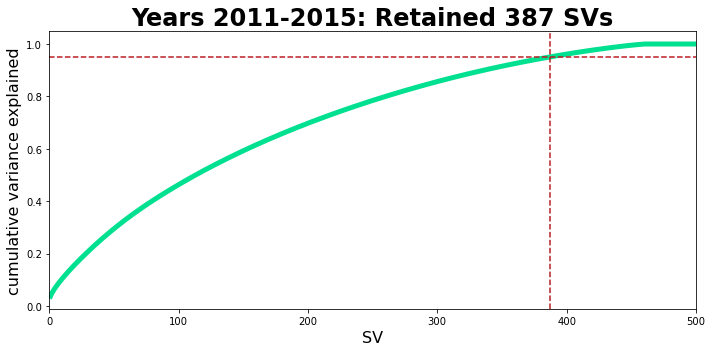

In [23]:
q_0610, s_0610, p_0610, nssd_0610 = truncated_svd(X_0610.todense())
k_0610 = plot_sv(nssd_0610, 0.95, title='Years 2006-2010')
q_1115, s_1115, p_1115, nssd_1115 = truncated_svd(X_1115.todense())
k_1115 = plot_sv(nssd_1115, 0.95, title='Years 2011-2015')
q_1621, s_1621, p_1621, nssd_1621 = truncated_svd(X_1621.todense())
k_1621 = plot_sv(nssd_1621, 0.95, title='Years 2016-2021')

Our team chose the corresponding number of singular values (SV) based on the explained variance that would retain most of the information from the data. We decided to have a 95% explained variance to retain 95% of the lyrics' meaning or text information. Based on the plots above, we reduced the dimensions from **11,262** to **1,191 SVs for the whole corpus, from 3,380 to 384 SVs for years 2006-2010, from 3,125 to 387 SVs for years 2011-2015, and 4404 to 465 SVs for years 2016-2021.**

#### Project SVD

In [24]:
X_all_lsa = project_svd(q_all, s_all, k_all)
X_0610_lsa = project_svd(q_0610, s_0610, k_0610)
X_1115_lsa = project_svd(q_1115, s_1115, k_1115)
X_1621_lsa = project_svd(q_1621, s_1621, k_1621)

Updated number of dimensions after using project_svd:

In [25]:
updated_n_dimensions()

All years n_dimensions: 1,191
2006-2010 n_dimensions: 384
2011-2015 n_dimensions: 387
2016-2021 n_dimensions: 465


<h1 style="color:#00e091">RESULTS AND DISCUSSIONS</h1>

In this study, we explored three methods in clustering the songs based on the prevailing themes or topics of the songs lyrics:

1. Nonnegative Matrix Factorization (NMF)
2. K-Means Clustering (K-Means)
3. Agglomerative Hierarchical Clustering (AHC)

<h2 style="color:#b91c20">NMF</h2>

### Finding the optimal K

The first step in using NMF is to find the optimal number of topics (clusters) or K. 

For interpretability, we only selected K for up to 10 and used elbow method of the reconstruction error (Frobenius norm of the matrix difference, between the training data and the reconstructed data from the fitted model) as a basis for finding the optimal K.

In [26]:
optimal_k_nmf(X_all)

'Optimal K for NMF Topics: 6'

### Top words per topic and distribution of topics per era

Print the top 15 words for 6 main topics identified using NMF function:

In [27]:
nmf_model_all, U_all, V_all = nmf_topics(X_all, X_all_feature_names, 15)

topic_results = nmf_model_all.transform(X_all)
df_all['topic'] = topic_results.argmax(axis=1)+1
df_all_nmf = nmf_topics_all(df_all)
display(df_all_nmf)

THE TOP 15 WORDS PER TOPIC 1
['take', 'would', 'see', 'make', 'love', 'back', 'feel', 'way', 'heart', 'life', 'away', 'say', 'cant', 'time', 'never']


THE TOP 15 WORDS PER TOPIC 2
['man', 'big', 'hit', 'back', 'bitches', 'ass', 'lil', 'real', 'woo', 'money', 'niggas', 'fuck', 'shit', 'bitch', 'nigga']


THE TOP 15 WORDS PER TOPIC 3
['want love', 'love girl love', 'want', 'hard love', 'love hard', 'love baby', 'lucky', 'love like', 'cant feel', 'hard', 'love girl', 'girl love', 'love love love', 'love love', 'love']


THE TOP 15 WORDS PER TOPIC 4
['little', 'boy', 'take', 'good', 'see', 'right', 'make', 'baby baby', 'body', 'tonight', 'need', 'want', 'wanna', 'girl', 'baby']


THE TOP 15 WORDS PER TOPIC 5
['low low', 'go head', 'back', 'dm', 'talking', 'never', 'ready', 'head', 'know know', 'time', 'never go', 'low', 'go go go', 'go go', 'go']


THE TOP 15 WORDS PER TOPIC 6
['see dance', 'plans', 'night', 'room', 'move move', 'living', 'way', 'floor', 'living room', 'stop', 'hands', 'm

2006-2010  2011-2015  2016-2021
topic                                 
1            217        199        206
2             65         67        177
3             25         32         28
4            119        139        124
5             41         31         42
6             33         31         22

### Display the songs included in each topic

In [28]:
display_topics(df_all, n_topics=6, samples=True, n_samples=3)

Topic 1


rank           song                               artist
0        1        Bad Day                        Daniel Powter
1298     1  Old Town Road  Lil Nas X Featuring Billy Ray Cyrus
1198     1     God's Plan                                Drake

Topic 2


rank           song                                  artist
300     1  Boom Boom Pow                     The Black Eyed Peas
699     1    Thrift Shop  Macklemore & Ryan Lewis Featuring Wanz
899     1   Uptown Funk!        Mark Ronson Featuring Bruno Mars

Topic 3


rank                   song                     artist
1098     1           Shape Of You                 Ed Sheeran
705      7  Just Give Me A Reason  P!nk Featuring Nate Ruess
306      7              I'm Yours                 Jason Mraz

Topic 4


rank               song                                     artist
100     1      Irreplaceable                                    Beyonce
999     1      Love Yourself                              Justin Bieber
501     2  Party Rock Anthem  LMFAO Featuring Lauren Bennett & GoonRock

Topic 5


rank     song                     artist
200      1      Low  Flo Rida Featuring T-Pain
1399     2  Circles                Post Malone
1000     2    Sorry              Justin Bieber

Topic 6


rank        song                         artist
400      1     TiK ToK                          Ke$ha
1498     1  Levitating                       Dua Lipa
1001     3   One Dance  Drake Featuring WizKid & Kyla

In [29]:
topic_word_list = plot_word_cloud(nmf_model_all, X_all_feature_names, k_all, 6)

After individually assessing the top words per topic, our team arrived at the following appropriate labels for each topic (cluster):

**SUMMARY OF TOPICS**

| TOPIC	| LABEL |
|:--| :--|
|Topic 1 |	Life, relationships, triumphs|
|Topic 2 |	Gangster culture, rhythmic, upbeat, and hiphop|
|Topic 3 |	Passionate, extreme love or loneliness, sexual|
|Topic 4 |	Rap and sexual|
|Topic 5 |	Catchy, easy recall, repetitive|
|Topic 6 |	Dance and party|

<center><span style="font-size:12px;color:#717171"><b>Table 3. </b>Summary of topics</span></center>

### Label the topics (clusters)

In [30]:
topic_dict ={1:'Life, relationships, triumphs',
             2:'Gangster culture, rhythmic, upbeat, and hiphop',
             3:'Passionate, extreme love or loneliness, sexual',
             4:'Rap and sexual',
             5:'Catchy, easy recall, repetitive',
             6:'Dance and party'}
df_all['topic_label'] = df_all['topic'].map(topic_dict)

In [31]:
df_all.head(2)

rank         song         artist  year  \
0     1      Bad Day  Daniel Powter  2006   
1     2  Temperature      Sean Paul  2006   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           lyrics  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                where is the moment we needed the most you kick up the leaves and the magic is lost they tell me your blue skies fade to gray they tell me your passions gone away and i dont need no carryin on you stand in the line just to hit a new low youre faking a smile with the coffee to go you tell me your lifes been way off line youre falling to pieces every time and i dont need no carryin on because you had a bad day youre taking one down you sing a sad song just to turn it around you say you dont know you tell me dont lie you work at a smile and you go for a ride you had a bad day the camera dont lie youre coming back down and you really dont mind you had a bad day you had a bad day will you need a blue sky holiday the point is they laugh at what you say and i dont need no carryin on you had a bad day youre taking one down you sing a sad song just to turn it around you say you dont know you tell me dont lie you work at a smile and you go for a ride you had a bad day the camera dont lie youre coming back down and you really dont mind you had a bad day ooh a holiday   
1  oh oh oh oh di gyaldem schillaci sean da paul suh mi give it to suh mi give it to suh mi give it to to all girls five million and forty naughty shorty baby girl all my girls all my girls sean da paul seh well woman the way the time cold i wanna be keepin you warm i got the right temperature fi shelter you from the storm oh lord gyal i got the right tactics to turn you on and girl i wanna be the papa you can be the mom oh oh make i see di gyal dem breakout pon di floor from you dont want no worthless performer oh oh from you dont want no man weh cant turn you on gyal make i see your hand dem up on ya oh oh cant tan pon it long nah eat no yam no steam fish nor no green banana oh oh but down in jamaica we give it to you hot like a sauna well woman the way the time cold i wan

### Test the results

For this step, our team tried different combinations of testing, but to avoid crowding this notebook with large printed dataframes, we'll just show the following instead:

**Show 10 samples of songs within the dance and party cluster:**

In [32]:
(df_all[df_all['topic_label'] == 'Dance and party']
 [['song', 'artist', 'year', 'topic_label']].drop_duplicates('song')
 .sort_values(by='topic_label').sample(10, random_state=44))

song  \
439       Club Can't Handle Me   
297             Into The Night   
24    Lean Wit It, Rock Wit It   
509               On The Floor   
864                       Dirt   
838                     Wiggle   
326                     Circus   
386                          3   
496                      Smile   
1498                Levitating   

                                                 artist  year      topic_label  
439                     Flo Rida Featuring David Guetta  2010  Dance and party  
297                      Santana Featuring Chad Kroeger  2008  Dance and party  
24    Dem Franchize Boyz Featuring Lil Peanut & Charlay  2006  Dance and party  
509                    Jennifer Lopez Featuring Pitbull  2011  Dance and party  
864                                Florida Georgia Line  2014  Dance and party  
838                   Jason Derulo Featuring Snoop Dogg  2014  Dance and party  
326                                      Britney Spears  2009  Dance and party  
386                                      Britney Spears  2009  Dance and party  
496                                       Uncle Kracker  2010  Dance and party  
1498                                           Dua Lipa  2021  Dance and party

**Famous artist:**

Since Taylor Swift is famous for making songs about her relationships and are usually has catchy or repetitive lyrics, we checked where her songs are clustered to:

In [33]:
(df_all[df_all['artist'] == 'Taylor Swift']
 [['song', 'year', 'topic_label']]
 .drop_duplicates('song').sort_values(by='topic_label'))[:10]

song  year                      topic_label
927                      Style  2015  Catchy, easy recall, repetitive
811               Shake It Off  2014  Catchy, easy recall, repetitive
188     Teardrops On My Guitar  2007    Life, relationships, triumphs
1221                  Delicate  2018    Life, relationships, triumphs
1136  Look What You Made Me Do  2017    Life, relationships, triumphs
955             Wildest Dreams  2015    Life, relationships, triumphs
769                         22  2013    Life, relationships, triumphs
1336     You Need To Calm Down  2019    Life, relationships, triumphs
714   I Knew You Were Trouble.  2013    Life, relationships, triumphs
572           Back To December  2011    Life, relationships, triumphs

**Based on the above table (and other samples we tested), we conclude that the clustering results of using NMF are appropriate and accurate.**

### Save the clustering results to each era

In [34]:
nmf_model_0610, U_0610, V_0610 = nmf_topics_era(X_0610, X_0610_feature_names, 15)
nmf_model_1115, U_1115, V_1115 = nmf_topics_era(X_1115, X_1115_feature_names, 15)
nmf_model_1621, U_1621, V_1621 = nmf_topics_era(X_1621, X_1621_feature_names, 15)

<h2 style="color:#b91c20">K-means Clustering</h2>

### Finding the optimal K

The first step in using K-Means clustering is also to find the optimal number of clusters or K.

For interpretability, we only selected K for up to 10 and used elbow method of the sum of squared distances, Silhouette score, and Davies Bouldin score as our considerations for finding the optimal K.

In [35]:
optimal_k(X_all_lsa, 5)

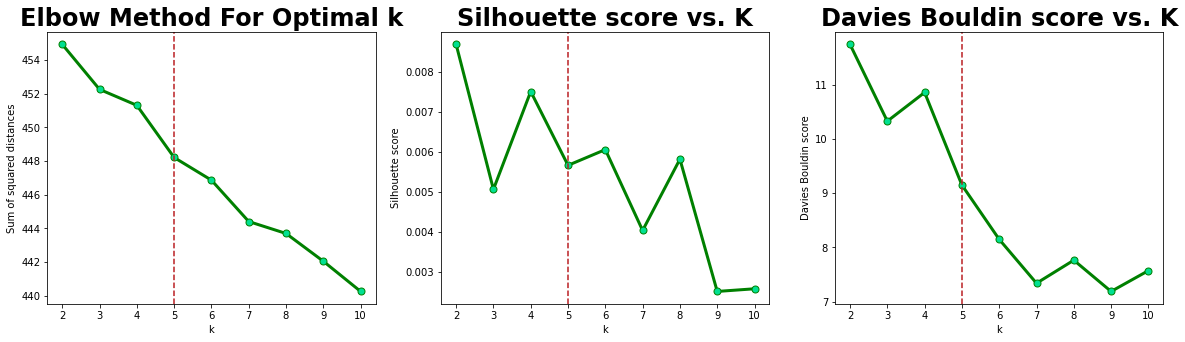

In [36]:
optimal_k(X_0610_lsa, 5)

In [37]:
optimal_k(X_1115_lsa, 4)

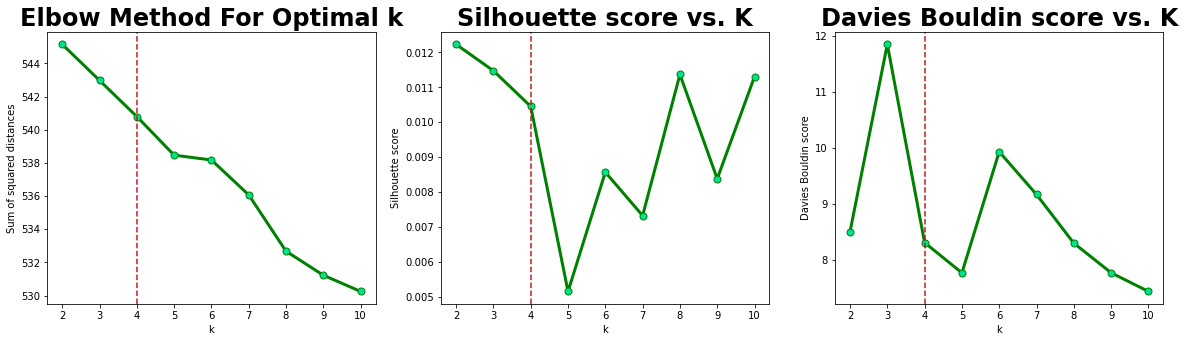

In [38]:
optimal_k(X_1621_lsa, 4)

### Implement K-Means Clustering using the optimal K

The following codes will show the K-Means clustered songs, display the tabular distribution of the clusters and sample songs from each cluster, and plot the results.

In [39]:
kmeans_all_labels = nmf_kmeans(X_all, U_all, 5)
df_all['k_cluster'] = kmeans_all_labels
display_k_clusters(df_all, 5)

k_cluster
0      49
1    1292
2      14
3     212
4      31
dtype: int64
Cluster 1


song                              artist
203         Lollipop    Lil Wayne Featuring Static Major
305      Right Round                            Flo Rida
8           SexyBack                   Justin Timberlake
410   Nothin' On You          B.o.B Featuring Bruno Mars
411        I Like It  Enrique Iglesias Featuring Pitbull
413       In My Head                        Jason Derulo
1214            Sad!                        XXXTENTACION
616   One More Night                            Maroon 5
817       Let Her Go                           Passenger
20        Move Along            The All-American Rejects

Cluster 2


song                               artist
0                          Bad Day                        Daniel Powter
1298                 Old Town Road  Lil Nas X Featuring Billy Ray Cyrus
200                            Low            Flo Rida Featuring T-Pain
300                  Boom Boom Pow                  The Black Eyed Peas
400                        TiK ToK                                Ke$ha
1198                    God's Plan                                Drake
1398               Blinding Lights                           The Weeknd
500            Rolling In The Deep                                Adele
1498                    Levitating                             Dua Lipa
599   Somebody That I Used To Know               Gotye Featuring Kimbra

Cluster 3


song                             artist
302                      Just Dance  Lady Gaga Featuring Colby O'Donis
408                        Dynamite                          Taio Cruz
1007        Can't Stop The Feeling!                  Justin Timberlake
809                          Timber            Pitbull Featuring Ke$ha
1411                   Dance Monkey                        Tones And I
32                     Dance, Dance                       Fall Out Boy
542                        Dynamite                          Taio Cruz
1146        Can't Stop The Feeling!                  Justin Timberlake
1160  Juju On That Beat (TZ Anthem)     Zay Hilfigerrr & Zayion McCall
1170          Chained To The Rhythm   Katy Perry Featuring Skip Marley

Cluster 4


song                               artist
899     Uptown Funk!     Mark Ronson Featuring Bruno Mars
1400         The Box                          Roddy Ricch
1101         Humble.                       Kendrick Lamar
1402        Rockstar         DaBaby Featuring Roddy Ricch
1302            Wow.                          Post Malone
1202        Rockstar      Post Malone Featuring 21 Savage
1103  Bad And Boujee         Migos Featuring Lil Uzi Vert
1203          Psycho  Post Malone Featuring Ty Dolla $ign
1004           Panda                            Desiigner
1404    Life Is Good               Future Featuring Drake

Cluster 5


song                          artist
705   Just Give Me A Reason       P!nk Featuring Nate Ruess
306               I'm Yours                      Jason Mraz
107        I Wanna Love You       Akon Featuring Snoop Dogg
407             Bad Romance                       Lady Gaga
910      Can't Feel My Face                      The Weeknd
521             How To Love                       Lil Wayne
1420           10,000 Hours      Dan + Shay & Justin Bieber
225                  Clumsy                          Fergie
824             Black Widow  Iggy Azalea Featuring Rita Ora
226               I'm Yours                      Jason Mraz

k_cluster
0    419
1      8
2     20
3     13
4     40
dtype: int64
Cluster 1


song                     artist
0          Bad Day              Daniel Powter
400        TiK ToK                      Ke$ha
100  Irreplaceable                    Beyonce
300  Boom Boom Pow        The Black Eyed Peas
200            Low  Flo Rida Featuring T-Pain
1      Temperature                  Sean Paul
401   Need You Now            Lady Antebellum
101       Umbrella    Rihanna Featuring Jay-Z
201  Bleeding Love                Leona Lewis
301     Poker Face                  Lady Gaga

Cluster 2


song  \
306             I'm Yours   
407           Bad Romance   
225                Clumsy   
226             I'm Yours   
427  Your Love Is My Drug   
134          Runaway Love   
465             Your Love   
396  Say Hey (I Love You)   

                                                    artist  
306                                             Jason Mraz  
407                                              Lady Gaga  
225                                                 Fergie  
226                                             Jason Mraz  
427                                                  Ke$ha  
134                       Ludacris Featuring Mary J. Blige  
465                                            Nicki Minaj  
396  Michael Franti & Spearhead Featuring Cherine Anderson

Cluster 3


song                              artist
203                         Lollipop    Lil Wayne Featuring Static Major
305                      Right Round                            Flo Rida
8                           SexyBack                   Justin Timberlake
410                   Nothin' On You          B.o.B Featuring Bruno Mars
411                        I Like It  Enrique Iglesias Featuring Pitbull
413                       In My Head                        Jason Derulo
20                        Move Along            The All-American Rejects
435                          How Low                            Ludacris
45                       Laffy Taffy                                 D4L
57   There It Go! (The Whistle Song)                       Juelz Santana

Cluster 4


song  \
412                   BedRock   
113     Party Like A Rockstar   
118              Fergalicious   
223                   So What   
24   Lean Wit It, Rock Wit It   
331               Let It Rock   
39                  Stickwitu   
344                   So What   
55                Do It To It   
264               Let It Rock   

                                                artist  
412                        Young Money Featuring Lloyd  
113                                          Shop Boyz  
118                                             Fergie  
223                                               P!nk  
24   Dem Franchize Boyz Featuring Lil Peanut & Charlay  
331                   Kevin Rudolf Featuring Lil Wayne  
39                                  The Pussycat Dolls  
344                                               P!nk  
55      Cherish Featuring Sean Paul Of The YoungBloodZ  
264                   Kevin Rudolf Featuring Lil Wayne

Cluster 5


song                                artist
404                     OMG             Usher Featuring will.i.am
304              Love Story                          Taylor Swift
4            Hips Don't Lie         Shakira Featuring Wyclef Jean
10           Be Without You                         Mary J. Blige
414                Rude Boy                               Rihanna
117           The Way I Are       Timbaland Featuring Keri Hilson
318  Kiss Me Thru The Phone  Soulja Boy Tell 'em Featuring Sammie
319                    Down          Jay Sean Featuring Lil Wayne
419                 Imma Be                   The Black Eyed Peas
22          Dani California                 Red Hot Chili Peppers

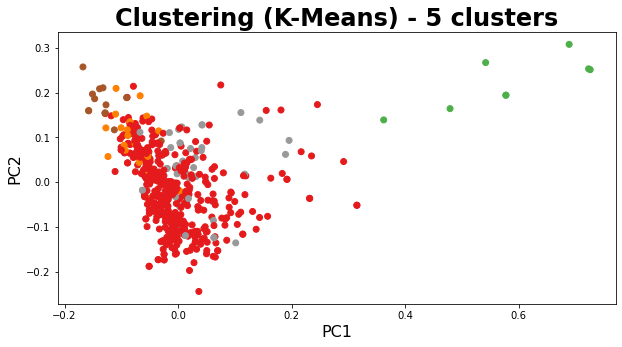

In [40]:
kmeans_0610_labels = nmf_kmeans(X_0610, U_0610, 5)
df_2006_2010['k_cluster'] = kmeans_0610_labels
display_k_clusters(df_2006_2010, 5)

k_cluster
0    426
1     12
2     51
3     10
dtype: int64
Cluster 1


song                                     artist
500           Rolling In The Deep                                      Adele
599  Somebody That I Used To Know                     Gotye Featuring Kimbra
799                         Happy                          Pharrell Williams
900             Thinking Out Loud                                 Ed Sheeran
800                    Dark Horse               Katy Perry Featuring Juicy J
600                 Call Me Maybe                           Carly Rae Jepsen
700                 Blurred Lines     Robin Thicke Featuring T.I. + Pharrell
501             Party Rock Anthem  LMFAO Featuring Lauren Bennett & GoonRock
801                     All Of Me                                John Legend
701                   Radioactive                            Imagine Dragons

Cluster 2


song  \
705                               Just Give Me A Reason   
910                                  Can't Feel My Face   
521                                         How To Love   
824                                         Black Widow   
726                                           I Love It   
729                                             The Way   
632                              As Long As You Love Me   
954                                      Love Me Harder   
672  Let Me Love You (Until You Learn To Love Yourself)   
784  Let Me Love You (Until You Learn To Love Yourself)   

                                 artist  
705           P!nk Featuring Nate Ruess  
910                          The Weeknd  
521                           Lil Wayne  
824      Iggy Azalea Featuring Rita Ora  
726      Icona Pop Featuring Charli XCX  
729  Ariana Grande Featuring Mac Miller  
632    Justin Bieber Featuring Big Sean  
954          Ariana Grande & The Weeknd  
672                               Ne-Yo  
784                               Ne-Yo

Cluster 3


song  \
699         Thrift Shop   
899        Uptown Funk!   
802               Fancy   
908           The Hills   
519      Look At Me Now   
618           The Motto   
720          Holy Grail   
922          Post To Be   
828               Loyal   
630  Young, Wild & Free   

                                                                    artist  
699                                 Macklemore & Ryan Lewis Featuring Wanz  
899                                       Mark Ronson Featuring Bruno Mars  
802                                       Iggy Azalea Featuring Charli XCX  
908                                                             The Weeknd  
519                         Chris Brown Featuring Lil Wayne & Busta Rhymes  
618                                              Drake Featuring Lil Wayne  
720                                      Jay Z Featuring Justin Timberlake  
922                             Omarion Featuring Chris Brown & Jhene Aiko  
828  Chris Brown Featuring Lil Wayne & French Montana Or Too $hort Or Tyga  
630                          Snoop Dogg & Wiz Khalifa Featuring Bruno Mars

Cluster 4


song                                   artist
616   One More Night                                 Maroon 5
817       Let Her Go                                Passenger
819        Let It Go                             Idina Menzel
736   One More Night                                 Maroon 5
551       Motivation        Kelly Rowland Featuring Lil Wayne
556        Rocketeer  Far*East Movement Featuring Ryan Tedder
859         Trumpets                             Jason Derulo
663         Let's Go            Calvin Harris Featuring Ne-Yo
589  Please Don't Go                              Mike Posner
795       Let Her Go                                Passenger

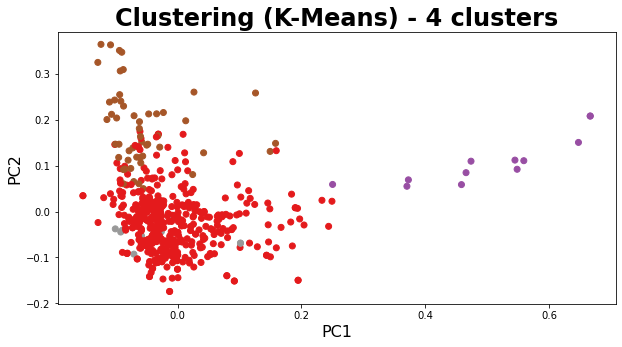

In [41]:
kmeans_1115_labels = nmf_kmeans(X_1115, U_1115, 4)
df_2011_2015['k_cluster'] = kmeans_1115_labels
display_k_clusters(df_2011_2015, 4)

k_cluster
0    103
1    362
2    127
3      7
dtype: int64
Cluster 1


song                                    artist
1498                      Levitating                                  Dua Lipa
1098                    Shape Of You                                Ed Sheeran
1100              That's What I Like                                Bruno Mars
1501                            Mood              24kGoldn Featuring iann dior
1503                    Kiss Me More                    Doja Cat Featuring SZA
1304                         7 Rings                             Ariana Grande
1504             Leave The Door Open  Silk Sonic (Bruno Mars & Anderson .Paak)
1006               Don't Let Me Down           The Chainsmokers Featuring Daya
1506  Montero (Call Me By Your Name)                                 Lil Nas X
1206                  In My Feelings                                     Drake

Cluster 2


song  \
999                                   Love Yourself   
1398                                Blinding Lights   
1198                                     God's Plan   
1298                                  Old Town Road   
1199                                        Perfect   
1099                                      Despacito   
1399                                        Circles   
1499                                Save Your Tears   
1000                                          Sorry   
1299  Sunflower (Spider-Man: Into The Spider-Verse)   

                                                 artist  
999                                       Justin Bieber  
1398                                         The Weeknd  
1198                                              Drake  
1298                Lil Nas X Featuring Billy Ray Cyrus  
1199                                         Ed Sheeran  
1099  Luis Fonsi & Daddy Yankee Featuring Justin Bieber  
1399                                        Post Malone  
1499                         The Weeknd & Ariana Grande  
1000                                      Justin Bieber  
1299                             Post Malone & Swae Lee

Cluster 3


song                               artist
1400         The Box                          Roddy Ricch
1101         Humble.                       Kendrick Lamar
1302            Wow.                          Post Malone
1402        Rockstar         DaBaby Featuring Roddy Ricch
1203          Psycho  Post Malone Featuring Ty Dolla $ign
1103  Bad And Boujee         Migos Featuring Lil Uzi Vert
1004           Panda                            Desiigner
1204       I Like It        Cardi B, Bad Bunny & J Balvin
1404    Life Is Good               Future Featuring Drake
1306      Sicko Mode                         Travis Scott

Cluster 4


song                            artist
1007        Can't Stop The Feeling!                 Justin Timberlake
1411                   Dance Monkey                       Tones And I
1146        Can't Stop The Feeling!                 Justin Timberlake
1160  Juju On That Beat (TZ Anthem)    Zay Hilfigerrr & Zayion McCall
1170          Chained To The Rhythm  Katy Perry Featuring Skip Marley
1474                     Only Human                    Jonas Brothers
1375                     Only Human                    Jonas Brothers

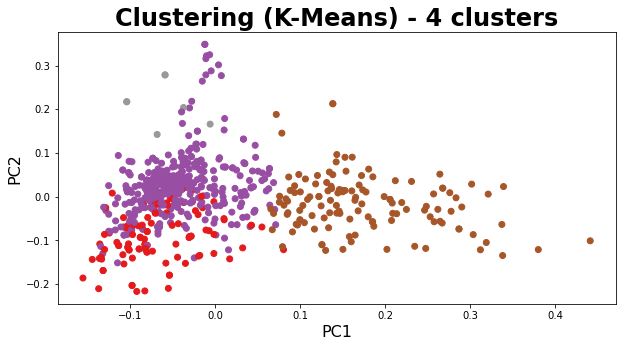

In [42]:
kmeans_1621_labels = nmf_kmeans(X_1621, U_1621, 4)
df_2016_2021['k_cluster'] = kmeans_1621_labels
display_k_clusters(df_2016_2021, 4)

<h2 style="color:#b91c20">Agglomerative Hierarchical Clustering</h2>

In [43]:
df_all = display_clusters(X_all_lsa, df_all, 5, samples=True)
plot_wcloud_ac(df_all, k_all, 5)

0    363
1    270
2    129
3    288
4    548
dtype: int64
Cluster 1


rank          song                                  artist
699     1   Thrift Shop  Macklemore & Ryan Lewis Featuring Wanz
899     1  Uptown Funk!        Mark Ronson Featuring Bruno Mars
301     2    Poker Face                               Lady Gaga

Cluster 2


rank           song                               artist
1298     1  Old Town Road  Lil Nas X Featuring Billy Ray Cyrus
200      1            Low            Flo Rida Featuring T-Pain
300      1  Boom Boom Pow                  The Black Eyed Peas

Cluster 3


rank           song       artist
1198     1     God's Plan        Drake
1098     1   Shape Of You   Ed Sheeran
201      2  Bleeding Love  Leona Lewis

Cluster 4


rank                          song                  artist
1398     1               Blinding Lights              The Weeknd
500      1           Rolling In The Deep                   Adele
599      1  Somebody That I Used To Know  Gotye Featuring Kimbra

Cluster 5


rank        song             artist
0        1     Bad Day      Daniel Powter
1498     1  Levitating           Dua Lipa
799      1       Happy  Pharrell Williams

Top 15 words for Cluster 1:
['like' 'got' 'know' 'get' 'bitch' 'nigga' 'shit' 'go' 'fuck' 'back'
 'money' 'see' 'girl' 'want' 'baby']

Top 15 words for Cluster 2:
['like' 'got' 'know' 'go' 'get' 'wanna' 'make' 'back' 'girl' 'rock' 'see'
 'time' 'good' 'take' 'right']

Top 15 words for Cluster 3:
['love' 'like' 'know' 'baby' 'got' 'want' 'girl' 'say' 'cant' 'never'
 'get' 'keep' 'need' 'take' 'tell']

Top 15 words for Cluster 4:
['love' 'know' 'baby' 'like' 'got' 'say' 'cant' 'never' 'want' 'need'
 'see' 'get' 'wanna' 'girl' 'feel']

Top 15 words for Cluster 5:
['know' 'like' 'go' 'wanna' 'got' 'time' 'baby' 'never' 'make' 'cant'
 'get' 'say' 'take' 'way' 'right']



#### 2006-2010 Clustering

0    170
1    178
2     44
3     44
4     64
dtype: int64
Cluster 1


rank              song           artist
401     2      Need You Now  Lady Antebellum
201     2     Bleeding Love      Leona Lewis
3       4  You're Beautiful      James Blunt

Cluster 2


rank           song                     artist
400     1        TiK ToK                      Ke$ha
300     1  Boom Boom Pow        The Black Eyed Peas
200     1            Low  Flo Rida Featuring T-Pain

Cluster 3


rank        song                             artist
301     2  Poker Face                          Lady Gaga
302     3  Just Dance  Lady Gaga Featuring Colby O'Donis
404     5         OMG          Usher Featuring will.i.am

Cluster 4


rank               song                             artist
2       3        Promiscuous  Nelly Furtado Featuring Timbaland
403     4   California Gurls    Katy Perry Featuring Snoop Dogg
207     8  Love In This Club        Usher Featuring Young Jeezy

Cluster 5


rank           song                   artist
0       1        Bad Day            Daniel Powter
100     1  Irreplaceable                  Beyonce
101     2       Umbrella  Rihanna Featuring Jay-Z

Top 15 words for Cluster 1:
['know' 'say' 'like' 'love' 'cant' 'time' 'never' 'got' 'see' 'life'
 'away' 'make' 'get' 'take' 'way']

Top 15 words for Cluster 2:
['like' 'got' 'go' 'know' 'get' 'wanna' 'make' 'see' 'right' 'girl' 'boy'
 'baby' 'rock' 'back' 'take']

Top 15 words for Cluster 3:
['love' 'know' 'like' 'girl' 'cant' 'got' 'baby' 'want' 'see' 'keep' 'way'
 'time' 'get' 'wanna' 'right']

Top 15 words for Cluster 4:
['baby' 'know' 'love' 'girl' 'like' 'got' 'want' 'get' 'wanna' 'take' 'ba'
 'see' 'boy' 'go' 'right']

Top 15 words for Cluster 5:
['like' 'know' 'right' 'get' 'make' 'go' 'time' 'got' 'take' 'say' 'wanna'
 'cant' 'way' 'back' 'never']



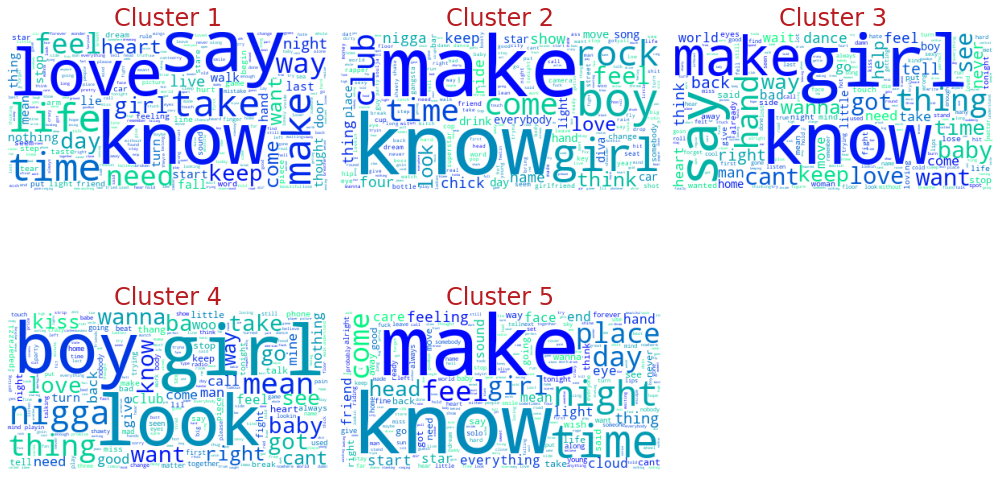

In [44]:
df_2006_2010 = display_clusters(X_0610_lsa, df_2006_2010, 5, samples=True)
plot_wcloud_ac(df_2006_2010, k_0610, 5)

#### 2011-2015 Clustering

0    204
1    119
2     87
3     89
dtype: int64
Cluster 1


rank                 song                        artist
0       1  Rolling In The Deep                         Adele
299     1                Happy             Pharrell Williams
300     2           Dark Horse  Katy Perry Featuring Juicy J

Cluster 2


rank           song                                  artist
199     1    Thrift Shop  Macklemore & Ryan Lewis Featuring Wanz
399     1   Uptown Funk!        Mark Ronson Featuring Bruno Mars
200     2  Blurred Lines  Robin Thicke Featuring T.I. + Pharrell

Cluster 3


rank                          song                              artist
99      1  Somebody That I Used To Know              Gotye Featuring Kimbra
400     2             Thinking Out Loud                          Ed Sheeran
401     3                 See You Again  Wiz Khalifa Featuring Charlie Puth

Cluster 4


rank               song                                        artist
1       2  Party Rock Anthem     LMFAO Featuring Lauren Bennett & GoonRock
203     5      Can't Hold Us  Macklemore & Ryan Lewis Featuring Ray Dalton
304     6         Talk Dirty               Jason Derulo Featuring 2 Chainz

Top 15 words for Cluster 1:
['like' 'know' 'never' 'go' 'come' 'got' 'wanna' 'baby' 'make' 'time'
 'cant' 'feel' 'love' 'get' 'back']

Top 15 words for Cluster 2:
['like' 'got' 'know' 'baby' 'get' 'girl' 'want' 'go' 'love' 'nigga'
 'money' 'make' 'wanna' 'back' 'shit']

Top 15 words for Cluster 3:
['love' 'like' 'baby' 'know' 'got' 'girl' 'never' 'need' 'cant' 'feel'
 'want' 'way' 'make' 'hard' 'see']

Top 15 words for Cluster 4:
['like' 'get' 'know' 'go' 'got' 'wanna' 'little' 'night' 'good' 'rock'
 'back' 'girl' 'baby' 'tell' 'make']



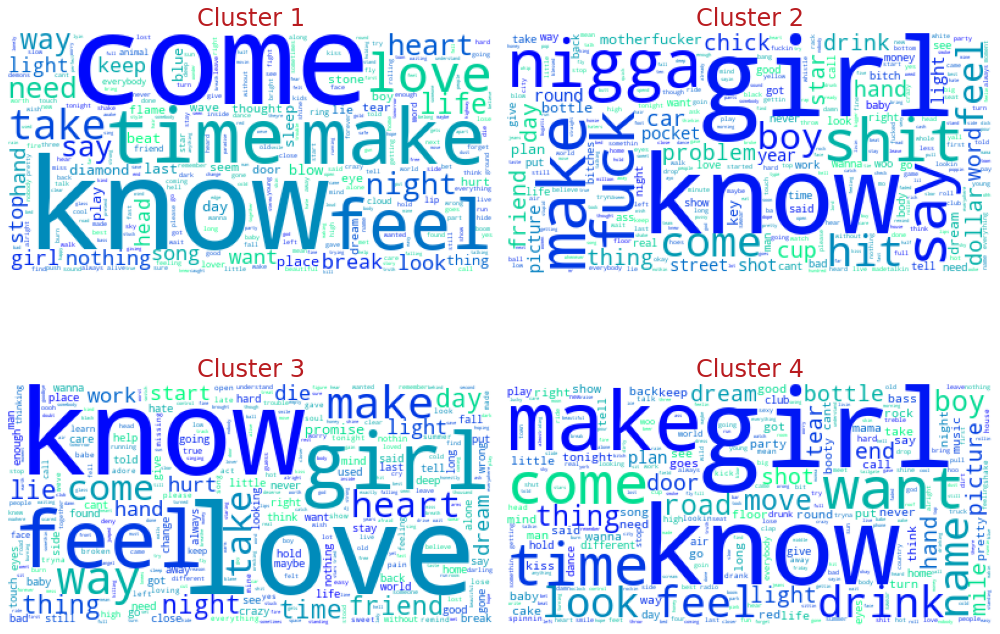

In [45]:
df_2011_2015 = display_clusters(X_1115_lsa, df_2011_2015, 4, samples=True, t=0.6)
plot_wcloud_ac(df_2011_2015, k_1115, 4)

#### 2016-2021 Clustering

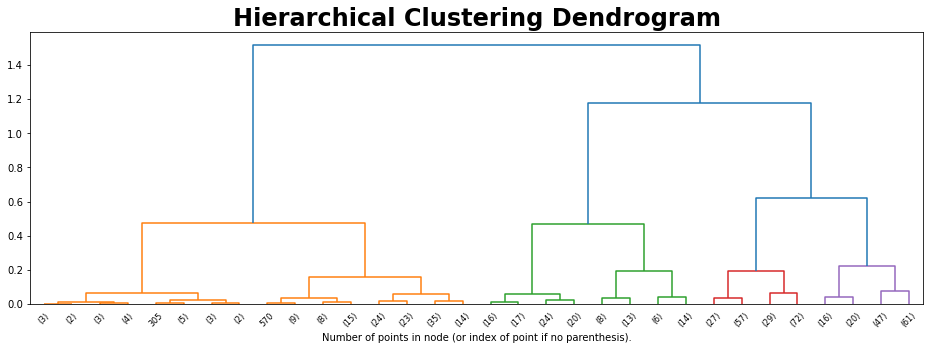

0    152
1    144
2    118
3    185
dtype: int64
Cluster 1


rank     song          artist
401     3  The Box     Roddy Ricch
102     4  Humble.  Kendrick Lamar
303     5     Wow.     Post Malone

Cluster 2


rank           song         artist
0       1  Love Yourself  Justin Bieber
199     1     God's Plan          Drake
99      1   Shape Of You     Ed Sheeran

Cluster 3


rank           song                                             artist
299     1  Old Town Road                Lil Nas X Featuring Billy Ray Cyrus
100     2      Despacito  Luis Fonsi & Daddy Yankee Featuring Justin Bieber
202     4         Havana                Camila Cabello Featuring Young Thug

Cluster 4


rank             song      artist
499     1       Levitating    Dua Lipa
399     1  Blinding Lights  The Weeknd
200     2          Perfect  Ed Sheeran

Top 15 words for Cluster 1:
['like' 'got' 'know' 'bitch' 'get' 'nigga' 'shit' 'fuck' 'go' 'niggas'
 'back' 'cant' 'want' 'money' 'lil']

Top 15 words for Cluster 2:
['love' 'know' 'like' 'baby' 'want' 'need' 'wanna' 'got' 'say' 'never'
 'tell' 'time' 'get' 'cant' 'go']

Top 15 words for Cluster 3:
['like' 'got' 'doo' 'know' 'back' 'gang' 'go' 'dance' 'work' 'cant' 'get'
 'woo' 'low' 'high' 'way']

Top 15 words for Cluster 4:
['know' 'like' 'go' 'cant' 'got' 'say' 'baby' 'way' 'love' 'never' 'need'
 'get' 'time' 'take' 'wanna']



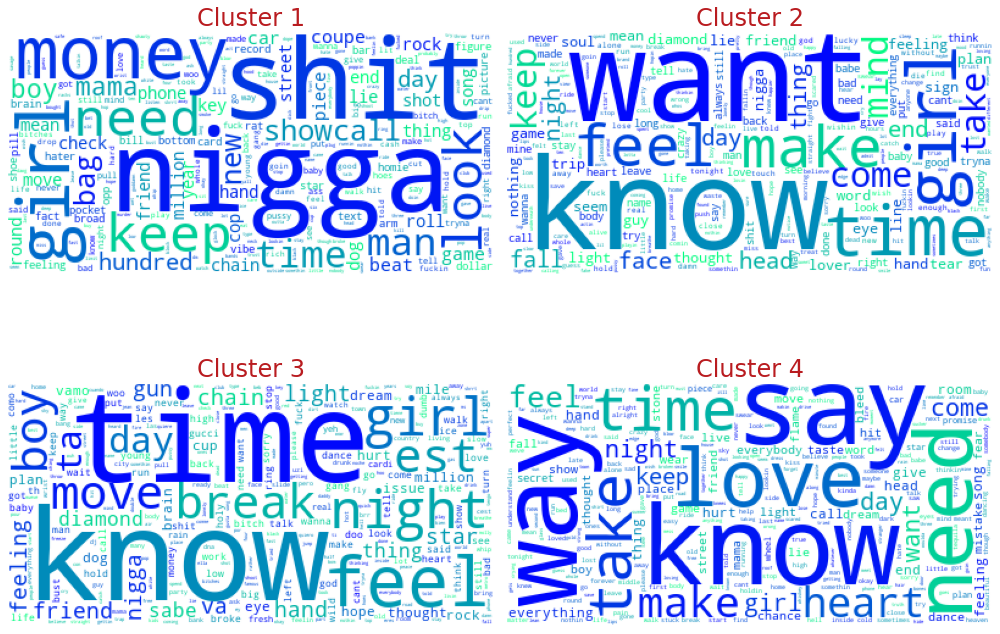

In [46]:
df_2016_2021 = display_clusters(X_1621_lsa, df_2016_2021, 4, samples=True, t=0.5)
plot_wcloud_ac(df_2016_2021, k_1621, 4)

<h2 style="color:#b91c20">Intepretation of Clustering Results</h2>

In this part, we assign the social tag associated with the clusters formed. These tags will be based on the top words and what that implies about the cluster. However, in the cases that there is no discernible theme just from the top words, the top-ranking words were used as basis for the social tag.

### 2006-2010 Clustering

Cluster 1 is labeled as **Romantic**, with `Love` as one of its top words. 

Cluster 2 is primarily composed of **Dance** and **Catchy** Songs. Looking at the top-ranking songs, it has lyrics that are easy to follow and are mostly repetitive

Cluster 3 also has `Love` as one of its top words however, what separates it from the previous cluster is that it is labeled as more **Passionate**

Cluster 4, similar to two previous clusters, is about `Love`. The songs in this cluster are more intimate and it was given a **Sexual** theme.

Cluster 5 was the cluster with the most indistinct songs, the topics were varying but it can be said that it is mostly about **Life** and tries to be relatable to the audience

### 2011-2015 Clustering

Cluster 1 has the **Life** social tag similar to the previous era. It mostly contains songs that people can relate to and has no significant top words.

Cluster 2 is a new cluster that emerged in this era, **Rap + Hip-hop**. The top words include the `expletives` and `money` which can be associated with the said genre, upon validating using the top-ranking songs, they are mostly sang by rappers.

Cluster 3 continues the three clusters about **Love** from the previous era. This time, all songs about `love` are found in a single cluster.

Cluster 4 contains songs that are expected to be played during **Dancing** or **Parties**. Some of the top words are `night` and `rock` explain the setting of such parties


### 2016-2021 Clustering

Cluster 1 is the biggest cluster in this era. It also represents the social tag **Life** which has been present in the last two eras.

Cluster 2 are mostly **Rap and Hip-hop** songs which became popular in the previous era.

Cluster 3 is about Love. Along with the Life cluster, this cluster is also present throughout all eras.  

Cluster 4 was labeled as **Gangster**, which is very similar with Cluster Rap and Hip-hop. A top word was `Gang` which was not top in the other similar cluster.

<h1 style="color:#00e091">RECOMMENDATIONS (for further studies and analyses)</h1>

**Future Work**

- Songwriters and artists can use lyric-based analysis and classification of the top songs over the years. They can use this to identify keywords and themes that recenlty successful songs have, and strategize what messages they want to include when crafting new songs. 

- The clusters formed by the models in this study can be used to generate playlists that have one common theme.

**Model Improvements**

- Increase the scope of our data by scraping more songs outside of the Hot-100. We can get more insights from the clustering and analyzing songs that aren't as successful as the top songs.

- Utilize metadata that will help identify the social tags of the clusters such as genre, sub-genres, song length, and others.

- Aside from the bare lyrics, we can use lyric interpretations from Genius.com or other sources. This will give more information about the context of songs, given that some songs don't directly say the message hidden behind the words.

- In this report the truncated SVD matrix was used for the Non-Negative Matrix Factorization clustering so that all three clustering methods had the same input. However, it is possible to use the raw TF-IDF matrix for NMF since it is also a dimensionality reduction method.

<h1 style="color:#00e091">CONCLUSION</h1>

We were able to successfully group different Hot-100 Billboard Songs from 2006 to 2021 into clusters and identify each cluster by social tags.

After exploring the three clustering methods, we were able to arrive at the following conclusion:
Overall/all year clustering results yielded `Life, relationships, triumphs`, `Gangster culture, rhythmic, upbeat, and hiphop`, `Passionate, extreme love or loneliness, sexual`, `Rap and sexual`, `Catchy, easy recall, repetitive`, and `Dance and party` as the main themes.

Whereas era clusters resulted to the following:
2006-2010's main themes are `Romantic`, `Dance and Catchy songs`, `Passiona`, `Sexual`, and `Life`.
2011-2015's main themes are `Life`, `Rap + Hip-hop`, `Love`, and `Dance and Party`.
2016-2021's main themes are `Life`, `Rap + Hip-hop`, `Love`, and `Gangster`. 

Also, it is worth highlighting the following notes:

**NMF**: clustering the dataset using the optimal k number of topics identified through NMF provided clustering results that are consistent and with no overlap.

**K-means Clustering**: this model was not able to properly segregate the data which could be due to the existence of outliers, high dimensionality, and sensitivity to the density of each cluster.

**Agglomerative Hierarchical Clustering**:  Was able to provide cleaner clustering than Kmeans, however, there were still some overlaps in the social tags available to each cluster. 

Overall, **NMF performed the best** among the three models used in terms of answering our problem statement.

<h1 style="color:#00e091">REFERENCES</h1>

<a name='Billboard'></a>[1] YEAR-END CHARTS Hot 100 Songs. (n.d). Billboard Website. https://www.billboard.com/charts/year-end/2021/hot-100-songs/. (accessed 2022, November)

<a name='Genius_API'></a>[2]  Getting Started. (n.d). Genius API Website. https://lyricsgenius.readthedocs.io/en/master/index.html. (accessed 2022, November)



**END**